<a href="https://colab.research.google.com/github/ZitongZhou/react_inverse/blob/master/ILUES_surrogate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install attrdict
!pip install --upgrade matplotlib

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.7/dist-packages (3.4.2)


In [4]:
from tqdm import tqdm
import numpy as np
import scipy.linalg
import pickle as pkl
import time
import sys
import os
import copy
import torch
import scipy.io
from attrdict import AttrDict
import argparse
from google.colab import drive
from google.colab import files
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from torch.utils.data import sampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, MultiStepLR
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
from torch.distributions import Gamma
from torchsummary import summary
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors
# import matplotlib.backends.backend_pdf
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# DenseED, Bayesian DenseED, and CAAE

In [5]:
"""
Convolutional Dense Encoder-Decoder Networks

Reference:
    https://github.com/pytorch/vision/blob/master/torchvision/models/densenet.py

Yinhao Zhu
Dec 21, 2017
Dec 30, 2017
Jan 03, 2018

Shaoxing Mo
May 07, 2019

Zitong Zhou
Feb 18, 2021
"""


class _DenseLayer(nn.Sequential):
    # bottleneck layer, bn_size: bottleneck size
    def __init__(self, in_features, growth_rate, drop_rate=0, bn_size=4,
                 bottleneck=False):
        # detect if the input features are more than bn_size x k,
        # if yes, use bottleneck -- not much memory gain, but lose one relu
        # I disabled the bottleneck for current implementation
        super(_DenseLayer, self).__init__()
        if bottleneck and in_features > bn_size * growth_rate:
            self.add_module('norm1', nn.BatchNorm3d(in_features))
            self.add_module('relu1', nn.ReLU(inplace=True))
            self.add_module('conv1', nn.Conv3d(in_features, bn_size *
                            growth_rate, kernel_size=1, stride=1, bias=False))
            self.add_module('norm2', nn.BatchNorm3d(bn_size * growth_rate))
            self.add_module('relu2', nn.ReLU(inplace=True))
            self.add_module('conv2', nn.Conv3d(bn_size * growth_rate, growth_rate,
                            kernel_size=3, stride=1, padding=1, bias=False))
        else:
            self.add_module('norm1', nn.BatchNorm3d(in_features))
            self.add_module('relu1', nn.ReLU(inplace=True))
            self.add_module('conv1', nn.Conv3d(in_features, growth_rate,
                            kernel_size=3, stride=1, padding=1, bias=False))
        self.drop_rate = drop_rate

    def forward(self, x):
        y = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            y = F.dropout3d(y, p=self.drop_rate, training=self.training)
        z = torch.cat([x, y], 1)
        return z


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, in_features, growth_rate, drop_rate,
                 bn_size=4, bottleneck=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(in_features + i * growth_rate, growth_rate,
                                drop_rate=drop_rate, bn_size=bn_size,
                                bottleneck=bottleneck)
            self.add_module('denselayer%d' % (i + 1), layer)

class _Transition(nn.Sequential):
    def __init__(self, in_features, out_features, encoding=True, drop_rate=0.,
                 last=False, out_channels=3, outsize_even=True):
        super(_Transition, self).__init__()
        self.add_module('norm1', nn.BatchNorm3d(in_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        if encoding:
            # reduce feature maps; half image size (input feature size is even)
            # bottleneck impl, save memory, add nonlinearity
            self.add_module('conv1', nn.Conv3d(in_features, out_features,
                                              kernel_size=1, stride=1,
                                              padding=0, bias=False))
            if drop_rate > 0:
                self.add_module('dropout1', nn.Dropout3d(p=drop_rate))
            self.add_module('norm2', nn.BatchNorm3d(out_features))
            self.add_module('relu2', nn.ReLU(inplace=True))
            self.add_module('conv2', nn.Conv3d(out_features, out_features,
                                              kernel_size=3, stride=2,
                                              padding=1, bias=False))
            if drop_rate > 0:
                self.add_module('dropout2', nn.Dropout3d(p=drop_rate))
        else:
            # decoding, transition up
            if last:
                ks = 6 if outsize_even else 5
                out_convt = nn.ConvTranspose3d(out_features, out_channels,
                                kernel_size=[2,ks,ks], stride=2, padding=[0,2,2],
                                output_padding=[0,0,0], bias=False)
            else:
                out_convt = nn.ConvTranspose3d(
                    out_features, out_features, kernel_size=3, stride=2,
                    padding=1, output_padding=0, bias=False)

            # bottleneck impl, save memory, add nonlinearity
            self.add_module('conv1', nn.Conv3d(in_features, out_features,
                                              kernel_size=1, stride=1,
                                              padding=0, bias=False))
            if drop_rate > 0:
                self.add_module('dropout1', nn.Dropout3d(p=drop_rate))

            self.add_module('norm2', nn.BatchNorm3d(out_features))
            self.add_module('relu2', nn.ReLU(inplace=True))
            self.add_module('convT2', out_convt)
            if drop_rate > 0:
                self.add_module('dropout2', nn.Dropout3d(p=drop_rate))

class DenseED(nn.Module):
    def __init__(self, in_channels, out_channels, blocks, growth_rate=16,
                 num_init_features=64, bn_size=4, drop_rate=0, outsize_even=False,
                 bottleneck=False):
        """
        Args:
            in_channels (int): number of input channels
            out_channels (int): number of output channels
            blocks: list (of odd size) of integers
            growth_rate (int): K
            num_init_features (int): the number of feature maps after the first
                conv layer
            bn_size: bottleneck size for number of feature maps (not useful...)
            bottleneck (bool): use bottleneck for dense block or not
            drop_rate (float): dropout rate
            outsize_even (bool): if the output size is even or odd (e.g.
                65 x 65 is odd, 64 x 64 is even)

        """
        super(DenseED, self).__init__()
        self.out_channels = out_channels

        if len(blocks) > 1 and len(blocks) % 2 == 0:
            ValueError('length of blocks must be an odd number, but got {}'
                       .format(len(blocks)))
        enc_block_layers = blocks[: len(blocks) // 2]
        dec_block_layers = blocks[len(blocks) // 2:]
        self.features = nn.Sequential()
        # First convolution ================
        # only conv, half image size
        self.features.add_module('in_conv',
                    nn.Conv3d(in_channels, num_init_features,
                            kernel_size=[3,7,7], stride=2, padding=[1,3,3], bias=False))

        # Encoding / transition down ================
        # dense block --> encoding --> dense block --> encoding
        num_features = num_init_features
        for i, num_layers in enumerate(enc_block_layers):
            block = _DenseBlock(num_layers=num_layers,
                                in_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate,
                                drop_rate=drop_rate, bottleneck=bottleneck)
            self.features.add_module('encblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate

            trans = _Transition(in_features=num_features,
                                out_features=num_features // 2,
                                encoding=True, drop_rate=drop_rate)
            self.features.add_module('down%d' % (i + 1), trans)
            num_features = num_features // 2

        # Decoding / transition up ==============
        # dense block --> decoding --> dense block --> decoding --> dense block
        # if len(dec_block_layers) - len(enc_block_layers) == 1:
        for i, num_layers in enumerate(dec_block_layers):
            block = _DenseBlock(num_layers=num_layers,
                                in_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate,
                                drop_rate=drop_rate, bottleneck=bottleneck)
            self.features.add_module('decblock%d' % (i + 1), block)
            num_features += num_layers * growth_rate

            # if this is the last decoding layer is the output layer
            last_layer = True if i == len(dec_block_layers) - 1 else False

            trans = _Transition(in_features=num_features,
                                out_features=num_features // 2,
                                encoding=False, drop_rate=drop_rate,
                                last=last_layer, out_channels=out_channels,
                                outsize_even=outsize_even)
            self.features.add_module('up%d' % (i + 1), trans)
            num_features = num_features // 2

    def forward(self, x):
        y = self.features(x)

        # #set the source point conc to be constant if there's release
        # nonzero_source = torch.nonzero(x[:,2,:,:,:])
        # # print('nonzero ',nonzero_source)
        # if len(nonzero_source) > 0:
        #     for non in nonzero_source:
        #         y[non[0],0,non[1],non[2],non[3]] = x[non[0],2,non[1],non[2],non[3]]
                
        # use the softplus activation for concentration and head
        y = F.softplus(y.clone(), beta=5)

        # CAUTION: if the last channel is pressure, 
        # use the sigmoid activation for pressure
        # y[:,self.out_channels-1] = torch.sigmoid(y[:,self.out_channels-1])

        return y

    def _num_parameters_convlayers(self):
        n_params, n_conv_layers = 0, 0
        for name, param in self.named_parameters():
            if 'conv' in name:
                n_conv_layers += 1
            n_params += param.numel()
        return n_params, n_conv_layers

    def _count_parameters(self):
        n_params = 0
        for name, param in self.named_parameters():
            print(name)
            print(param.size())
            print(param.numel())
            n_params += param.numel()
            print('num of parameters so far: {}'.format(n_params))

    def reset_parameters(self, verbose=False):
        for module in self.modules():
            # pass self, otherwise infinite loop
            if isinstance(module, self.__class__):
                continue
            if 'reset_parameters' in dir(module):
                if callable(module.reset_parameters):
                    module.reset_parameters()
                    if verbose:
                        print("Reset parameters in {}".format(module))
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.cpu().detach().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or '\
            'np.ndarray, but got {}'.format(type(input)))
        

def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    eps = torch.randn_like(std)
    #randn_like: Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.
    #return: random gaussian sample from distribution with mu and exp(logvar/2)
    return mu + eps*std


class DenseResidualBlock(nn.Module):
    """
    The core module of paper: (Residual Dense Network for Image Super-Resolution, CVPR 18)
    """

    def __init__(self, filters, res_scale=0.2):
        super(DenseResidualBlock, self).__init__()
        self.res_scale = res_scale

        def block(in_features, non_linearity=True):
            layers = [nn.BatchNorm3d(in_features)]
            layers += [nn.ReLU(inplace=True)]
            layers += [nn.Conv3d(in_features, filters, 3, 1, 1, bias=True)] # does not change state size
            return nn.Sequential(*layers)

        self.b1 = block(in_features=1 * filters)
        self.b2 = block(in_features=2 * filters)
        self.b3 = block(in_features=3 * filters)
        self.b4 = block(in_features=4 * filters)
        self.b5 = block(in_features=5 * filters, non_linearity=False)
        self.blocks = [self.b1, self.b2, self.b3, self.b4, self.b5]

    def forward(self, x):
        inputs = x
        for block in self.blocks:
            out = block(inputs)
            inputs = torch.cat([inputs, out], 1)
        return out.mul(self.res_scale) + x


class ResidualInResidualDenseBlock(nn.Module):
    def __init__(self, filters, res_scale=0.2):
        super(ResidualInResidualDenseBlock, self).__init__()
        self.res_scale = res_scale
        self.dense_blocks = nn.Sequential(
            DenseResidualBlock(filters), DenseResidualBlock(filters), DenseResidualBlock(filters)#, DenseResidualBlock(filters)
        )

    def forward(self, x):
        return self.dense_blocks(x).mul(self.res_scale) + x

class Encoder(nn.Module):
    def __init__(self, inchannels=1, outchannels=2, filters=48, num_res_blocks=1):
        super(Encoder, self).__init__()
        # input size, inchannels x 6 x 41 x 81
        self.conv1 = nn.Conv3d(inchannels, filters, kernel_size=3, stride=2, padding=1)
        # state size. filters x 3 x 21 x 41
        self.res_blocks = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for _ in range(num_res_blocks)])
        # state size. filters x 3 x 21 x 41
        self.trans = nn.Sequential(
            nn.BatchNorm3d(filters),
            nn.ReLU(inplace=True),
            nn.Conv3d(filters, filters, kernel_size=3, stride=2, padding=1),
        )
        # state size. filters x 2 x 11 x 21
        self.mu = nn.Conv3d(filters, outchannels, 3, 1, 1, bias=False) #does not change state size.
        self.logvar = nn.Conv3d(filters, outchannels, 3, 1, 1, bias=False) #does not change state size.

    def forward(self, img):
        # img: inchannels x 6 x 41 x 81
        out1 = self.conv1(img)        # filters x 3 x 21 x 41
        out2 = self.res_blocks(out1)   # filters x 3 x 21 x 41
        out3 = self.trans(out2)        # filters x 2 x 11 x 21

        mu, logvar = self.mu(out3), self.logvar(out3)
        z = reparameterization(mu, logvar) # latent dimension: outchannels x 2 x 11 x 21
        return z

    def _n_parameters(self):
        n_params = 0
        for name, param in self.named_parameters():
            n_params += param.numel()
        return n_params
                
class Decoder(nn.Module):
    def __init__(self, inchannels=2, outchannels=1, filters=48, num_res_blocks=1,num_upsample=2):
        super(Decoder, self).__init__()

        # First layer. input size, inchannels x 2 x 8 x 16
        self.conv1 = nn.Conv3d(inchannels, filters, kernel_size=3, stride=1, padding=1)

        # state size. filters x 2 x 8 x 16
        # Residual blocks
        self.res_block1 = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for _ in range(num_res_blocks+1)])
        self.transup1 = nn.Sequential(
            nn.BatchNorm3d(filters),
            nn.ReLU(inplace=True),
            nn.Upsample(size=(4, 21, 41), mode='nearest'),
            nn.Conv3d(filters, filters, kernel_size=3, stride=1, padding=1), #does not change state size
        )
        self.res_block2 = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for _ in range(num_res_blocks)])
        self.transup2 = nn.Sequential(
            nn.BatchNorm3d(filters),
            nn.ReLU(inplace=True),
            nn.Upsample(size=(8, 41, 81), mode='nearest'),
            nn.Conv3d(filters, outchannels, kernel_size=3, stride=1, padding=(0,1,1)), # reduce the first dimension by 2
        )


    def forward(self, z):
        # x: in_channels x 2 x 8 x 16
        out1 = self.conv1(z)          # filters x 2 x 8 x 16
        out2 = self.res_block1(out1)   # filters x 2 x 8 x 16
        out = torch.add(out1, out2)   # filters x 2 x 8 x 16
        out3 = self.transup1(out)      # filters x 4 x 16 x 32
        out4 = self.res_block2(out3)   # filters x 4 x 16 x 32

        img = self.transup2(out4)     # outchannels x 6 x 32 x 64

        return img

    def _n_parameters(self):
        n_params= 0
        for name, param in self.named_parameters():
            n_params += param.numel()
        return n_params

In [6]:
"""
Particle approximations for posterior of Bayesian neural net used in SVGD.

References:
    Liu, Qiang, and Dilin Wang. "Stein variational gradient descent:
    A general purpose bayesian inference algorithm." NIPS. 2016.

methods:
    __init__
    forward
    compute_loss
    compute_mse_nlp
    predict
    propagate

Note: 
`torch.distributions` is not much used in this implementation to keep simple.
Also we trade computing for memory by using for-loop rather than in a batch way.
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class BayesNN(nn.Module):
    """Class for Bayesian NNs with Stein Variational Gradient Descent.
    Not for usage independently.
    
    Bayesian NNs: y = f(x, w) + n

    uncertain weights:
            w_i ~ Normal(w_i | mu=0, 1 / alpha) 
            alpha ~ Gamma(alpha | shape=1, rate=0.05) (shared)
            --> w_i ~ StudentT(w_i | mu=0, lambda=shape/rate, nu=2*shape)
            Parameterization of StudentT in Bishop p.103 Eq. (2.159)

    Assumptions on noise:
        Additive, Gaussian, homoscedastic (independent of input), 
        output wise (same for every pixels in the output).
            n ~ Normal(0, 1 / beta)
            beta ~ Gamma(beta | shape=2, rate=2e-6)

    Hyperparameters for weights and noise are pre-defined based on heuristic.

    Given a deterministic `model`, initialize `n_samples` replicates
    of the `model`. (plus `n_samples` of noise precision realizations)

    `model` must implement `reset_parameters` method for the replicates
    to have different initial realizations of uncertain parameters.

    References:
        Liu, Qiang, and Dilin Wang. "Stein variational gradient descent:
        A general purpose bayesian inference algorithm."
        Advances In Neural Information Processing Systems. 2016.

    Args:
        model (nn.Module): The deterministic NN to be instantiated `n_samples` 
            times
        data_loader (utils.data.DataLoader): For training and testing
        n_samples (int): Number of samples for uncertain parameters
    """
    def __init__(self, model, n_samples=20):
        super(BayesNN, self).__init__()
        if not isinstance(model, nn.Module):
            raise TypeError("model {} is not a Module subclass".format(
                torch.typename(model)))

        self.n_samples = n_samples

        # w_i ~ StudentT(w_i | mu=0, lambda=shape/rate, nu=2*shape)
        # for efficiency, represent StudentT params using Gamma params
        self.w_prior_shape = 1.
        self.w_prior_rate = 0.05
        
        # noise variance 1e-6: beta ~ Gamma(beta | shape, rate)
        self.beta_prior_shape = 2.
        self.beta_prior_rate = 1.e-6

        # replicate `n_samples` instances with the same network as `model`
        instances = []
        for i in range(n_samples):
            new_instance = copy.deepcopy(model)
            # initialize each model instance with their defualt initialization
            # instead of the prior
            new_instance.reset_parameters()
            print('Reset parameters in model instance {}'.format(i))
            instances.append(new_instance)
        self.nnets = nn.ModuleList(instances)
        del instances

        # log precision (Gamma) of Gaussian noise
        log_beta = Gamma(self.beta_prior_shape, 
                         self.beta_prior_rate).sample((self.n_samples,)).log()
        for i in range(n_samples):
            self.nnets[i].log_beta = Parameter(log_beta[i])

        print('Total number of parameters: {}'.format(self._num_parameters()))

    def _num_parameters(self):
        count = 0
        for name, param in self.named_parameters():
            # print(name)
            count += param.numel()
        return count

    def __getitem__(self, idx):
        return self.nnets[idx]

    @property
    def log_beta(self):
        return torch.tensor([self.nnets[i].log_beta.item() 
            for i in range(self.n_samples)], device=device)

    def forward(self, input):
        """Computes all the `n_samples` NN output
        Args:
            input: N x iC x iH x iW

        Return:
            output: S x N x oC x oH x oW
        """
        output = []
        for i in range(self.n_samples):
            output.append(self.nnets[i].forward(input))
        output = torch.stack(output)

        return output

    def _log_joint(self, index, output, target, ntrain):
        """Log joint probability or unnormalized posterior for single model
        instance. Ignoring constant terms for efficiency.
        Can be implemented in batch computation, but memory is the bottleneck.
        Thus here we trade computation for memory, e.g. using for loop.

        Args:
            index (int): model index, 0, 1, ..., `n_samples`
            output (Tensor): B x oC x oD x oH x oW
            target (Tensor): B x oC x oD x oH x oW
            ntrain (int): total number of training data, mini-batch is used to
                evaluate the log joint prob

        Returns:
            Log joint probability (zero-dim tensor)
        """
        # Normal(target | output, 1 / beta * I)
        log_likelihood = ntrain / output.size(0) * (
                            - 0.5 * self.nnets[index].log_beta.exp()
                            * (target - output).pow(2).sum()
                            + 0.5 * target.numel() * self.nnets[index].log_beta)
        # log prob of prior of weights, i.e. log prob of studentT
        log_prob_prior_w = torch.tensor(0.).to(device)
        for param in self.nnets[index].features.parameters():
            log_prob_prior_w += \
                torch.log1p(0.5 / self.w_prior_rate * param.pow(2)).sum()
        log_prob_prior_w *= -(self.w_prior_shape + 0.5)
        # log prob of prior of log noise-precision (NOT noise precision)
        log_prob_prior_log_beta = ((self.beta_prior_shape-1.0) * self.nnets[index].log_beta \
                    - self.nnets[index].log_beta.exp() * self.beta_prior_rate)
        return log_likelihood + log_prob_prior_w + log_prob_prior_log_beta


    def _compute_mse_nlp(self, input, target, size_average=True, out=False):
        """Evaluate the MSE and Negative Log Probability.

        Args:
            input (Tensor): (N, iC, iH, iW)
            target (Tensor): (N, oC, oH, oW)
            size_average (bool)
            out (bool): If True, return output of `bayes_nn` w. `input`

        Returns:
            (mse, nlp) if `out` is False, o.w. (mse, nlp, output)
            where output is of size (S, N, oC, oH, oW)
        """
        # S x N x oC x oH x oW
        output = self.forward(input)
        # S x 1 x 1 x 1 x 1
        log_beta = self.log_beta.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        log_2pi_S = torch.tensor(0.5 * target[0].numel() * math.log(2 * math.pi)
                       + math.log(self.n_samples), device=device)
        # S x N
        # print(log_beta.exp().shape)
        # print(((target - output) ** 2).shape)
        exponent = - 0.5 * (log_beta.exp() * ((target - output) ** 2)).view(
            self.n_samples, target.size(0), -1).sum(-1) \
                    + 0.5 * target[0].numel() * self.log_beta.unsqueeze(-1)

        # n = target[0].numel()
        nlp = - log_sum_exp(exponent, dim=0).mean() + log_2pi_S
        mse = ((target - output.mean(0)) ** 2).mean()

        if not size_average:
            mse *= target.numel()
            nlp *= target.size(0)
        if not out:
            return mse, nlp
        else:
            return mse, nlp, output


    def predict(self, x_test):
        """
        Predictive mean and variance at x_test. (only average over w and beta)
        Args:
            x_test (Tensor): [N, *], test input
        """
        # S x N x oC x oH x oW
        y = self.forward(x_test)
        y_pred_mean = y.mean(0)
        # compute predictive variance per pixel
        # N x oC x oH x oW
        EyyT = (y ** 2).mean(0)
        EyEyT = y_pred_mean ** 2
        beta_inv = (- self.log_beta).exp()
        y_pred_var = beta_inv.mean() + EyyT - EyEyT

        return y_pred_mean, y_pred_var


    def propagate(self, mc_loader):
        """
        Mean and Variance statistics of predictive output distribution
        averaging over the input distribution, i.e. uncertainty propagation.

        First compute the conditional predictive mean and var given realizations
        of uncertain surrogate; then compute the statistics of those conditional
        statistics.

        Args:
            mc_loader (torch.utils.data.DataLoader): dataloader for the Monte 
                Carlo data (10,000 is used in this work)

            S: num of samples
            M: num of data
            D: output dimensions
        """
        # First compute conditional statistics
        # S x N x oC x oH x oW
        # self.cpu()
        # x_test = x_test.cpu()
        # print('here')

        # S x oC x oH x oW
        output_size = mc_loader.dataset[0][1].size()
        cond_Ey = torch.zeros(self.n_samples, *output_size, device=device)
        cond_Eyy = torch.zeros_like(cond_Ey)

        for _, (x_mc, _) in enumerate(mc_loader):
            x_mc = x_mc.to(device)
            # S x B x oC x oH x oW            
            y = self.forward(x_mc)
            cond_Ey += y.mean(1)
            cond_Eyy += y.pow(2).mean(1)
        cond_Ey /= len(mc_loader)
        cond_Eyy /= len(mc_loader)
        beta_inv = (- self.log_beta).exp()
        print('Noise variances: {}'.format(beta_inv))
        
        y_cond_pred_var = cond_Eyy - cond_Ey ** 2 \
                     + beta_inv.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

        # compute statistics of conditional statistics
        return cond_Ey.mean(0), cond_Ey.var(0), \
               y_cond_pred_var.mean(0), y_cond_pred_var.var(0)



# load CAAE and Bayesian DenseED models

In [7]:
'''Load the CAAE model first'''
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
n_train = 23000
n_test = 100
batch_size = 64
n_epochs = 50
lr = 0.0002 ## adam learning rate
lw = 0.01 ## "adversarial loss weight"

current_dir = "/content/drive/MyDrive/react_inverse/CAAE/"
date = 'experiments/Feb_14_CAAE3D'
exp_dir = current_dir + date + "/N{}_Bts{}_Eps{}_lr{}_lw{}".\
    format(n_train, batch_size, n_epochs, lr, lw)

output_dir = exp_dir + "/predictions"
model_dir = exp_dir

nf, d, h, w = 2, 2, 11, 21

# Initialize encoder
encoder = Encoder(outchannels=nf)
encoder.load_state_dict(torch.load(model_dir + '/AAE_encoder_epoch{}.pth'.format(n_epochs)))
if cuda:
    encoder.cuda()

encoder.eval()

# Initialize decoder
decoder = Decoder(inchannels=nf)
decoder.load_state_dict(torch.load(model_dir + '/AAE_decoder_epoch{}.pth'.format(n_epochs)))
if cuda:
    decoder.cuda()

decoder.eval()

Decoder(
  (conv1): Conv3d(2, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (res_block1): Sequential(
    (0): ResidualInResidualDenseBlock(
      (dense_blocks): Sequential(
        (0): DenseResidualBlock(
          (b1): Sequential(
            (0): BatchNorm3d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv3d(48, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (b2): Sequential(
            (0): BatchNorm3d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv3d(96, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (b3): Sequential(
            (0): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv3d(144, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), paddin

In [8]:
# exp_dir = "/content/drive/MyDrive/react_inverse/Bayesian_DenseED"
# all_over_again = 'Apr_04'
# n_samples = 20
# n_train = 1000
# batch_size = 40
# lr = 0.005
# lr_noise = 0.01
# n_epochs = 300
# ckpt_epoch = None
# run_dir = exp_dir + '/' + all_over_again\
#     + '/ns{}_ntr{}_bt{}_lr{}_lrn{}_ep{}'.format(
#         n_samples, n_train, batch_size, lr,
#         lr_noise, n_epochs)
# pred_dir = run_dir + '/predictions'
# ckpt_dir = run_dir + '/checkpoints'
# nic = 3
# noc = 2
# blocks = [3,6,3]
# growth_rate = 40
# init_features = 48
# drop_rate = 0.
# bn_size = 8
# bottleneck = False

# dense_ed = DenseED(
#     in_channels=nic, 
#     out_channels=noc, 
#     blocks=blocks,
#     growth_rate=growth_rate, 
#     num_init_features=init_features,
#     drop_rate=drop_rate,
#     bn_size=bn_size,
#     bottleneck=bottleneck,
# )
# # print(dense_ed)
# # Bayesian NN
# bayes_nn = BayesNN(dense_ed, n_samples=n_samples).to(device)
# # load the pre-trained model
# if ckpt_epoch is not None:
#     checkpoint = ckpt_dir + '/model_epoch{}.pth'.format(ckpt_epoch)
# else:
#     checkpoint = ckpt_dir + '/model_epoch{}.pth'.format(n_epochs)
# bayes_nn.load_state_dict(torch.load(checkpoint))
# print('Loaded pre-trained model: {}'.format(checkpoint))
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # training on GPU or CPU


# Dense ED deterministic

In [9]:
parser = argparse.ArgumentParser(description='Dnense Encoder-Decoder Convolutional Network')
parser.add_argument('-f')
parser.add_argument('--exp-name', type=str, default='AR-Net-WL-source', help='experiment name')
parser.add_argument('--blocks', type=list, default=(3, 6, 3), help='list of number of layers in each block in decoding net')
parser.add_argument('--growth-rate', type=int, default=48, help='output of each conv')
parser.add_argument('--drop-rate', type=float, default=0, help='dropout rate')
parser.add_argument('--bn-size', type=int, default=8, help='bottleneck size: bn_size * growth_rate')
parser.add_argument('--bottleneck', action='store_true', default=False, help='enable bottleneck in the dense blocks')
parser.add_argument('--init-features', type=int, default=48, help='# initial features after the first conv layer')

parser.add_argument('--data-dir', type=str, default="/content/drive/MyDrive/react_inverse/dense_ed_3d/", help='data directory')
parser.add_argument('--n-train', type=int, default=4000, help="number of training data")
parser.add_argument('--n-test', type=int, default=1000, help="number of test data")

parser.add_argument('--w-c', type=float, default=5.0, help='weight value in the weighted loss')
parser.add_argument('--n-epochs', type=int, default=200, help='number of epochs to train (default: 200)')
parser.add_argument('--lr', type=float, default=0.005, help='learnign rate')
parser.add_argument('--weight-decay', type=float, default=5e-5, help="weight decay")
parser.add_argument('--batch-size', type=int, default=32, help='input batch size for training (default: 100)')
parser.add_argument('--test-batch-size', type=int, default=64, help='input batch size for testing (default: 100)')
parser.add_argument('--log-interval', type=int, default=50, help='how many epochs to wait before logging training status')
parser.add_argument('--plot-interval', type=int, default=50, help='how many epochs to wait before plotting training status')

args = parser.parse_args()

all_over_again = 'May_16'

exp_dir = args.data_dir + all_over_again + "/{}/Ntrs{}__Bks{}_Bts{}_Eps{}_wd{}_lr{}_K{}_w_c{}".\
    format(args.exp_name, args.n_train,args.blocks,
           args.batch_size, args.n_epochs, args.weight_decay, args.lr, args.growth_rate,args.w_c)

output_dir = exp_dir + "/predictions"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseED(3, 2, blocks=args.blocks, growth_rate=args.growth_rate,
                drop_rate=args.drop_rate, bn_size=args.bn_size,
                num_init_features=args.init_features, bottleneck=args.bottleneck).to(device)
print("number of parameters: {}\nnumber of layers: {}"
              .format(*model._num_parameters_convlayers()))

model_dir = exp_dir
model.load_state_dict(torch.load(model_dir+'/model_epoch'+'{}'.format(args.n_epochs)+'.pth'))

number of parameters: 4424064
number of layers: 19


<All keys matched successfully>

In [10]:
def plot_3d(data, title='', cut=None):
    data = np.transpose(data, (2, 1, 0))
    data = np.flip(data, axis=2)
    filled = np.ones(data.shape)
    if cut is not None:
        filled[cut[2]:, :cut[1], (6-cut[0]):] = 0
    x, y, z = np.indices(np.array(filled.shape) + 1)
    
    v1 = np.linspace(np.min(data),np.max(data), 8, endpoint=True)
    norm = matplotlib.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.voxels(x, y, z, filled, facecolors=plt.cm.jet(norm(data)), edgecolors=None, 
              )
    ax.set_box_aspect((250, 125, 50))
    
    m = cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
    m.set_array([])
    fig.colorbar(m, ax=ax, fraction=0.015, pad=0.04,ticks=v1,)
    ax.set_axis_off()
    plt.tight_layout()
    # ax.set_title(title)
    plt.savefig(title+'.pdf',bbox_inches='tight')
    return fig
# fig = plot_3d(log_K[0,], title='', cut=[3, 13+1, 20-1])

def plot_3d_2(real, gen, title='', cut=None):
    fig = plt.figure()
    data_all = [real, gen]
    vmin = np.min(np.array(data_all))
    vmax = np.max(np.array(data_all))
    
    v1 = np.linspace(vmin,vmax, 8, endpoint=True)
    i = 1
    titles = ['real', 'generated']
    for ind, data in enumerate(data_all):
        data = np.transpose(data, (2, 1, 0))
        data = np.flip(data, axis=2)
        filled = np.ones(data.shape)
        if cut is not None:
            filled[cut[2]:, :cut[1], (6-cut[0]):] = 0
        x, y, z = np.indices(np.array(filled.shape) + 1)
        
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        
        ax = fig.add_subplot(1, 2, i, projection='3d')
        ax.voxels(x, y, z, filled, facecolors=plt.cm.jet(norm(data)), edgecolors=None)
        ax.set_box_aspect([250, 125, 50])
        ax.set_title(titles[ind])
        m = cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
        m.set_array([])
        ax.set_axis_off()
        i += 1
    fig.colorbar(m, ax=ax, fraction=0.015, pad=0.04, ticks=v1,)
        
    plt.tight_layout()
    # ax.set_title(title)
    plt.savefig(title+'.pdf',bbox_inches='tight')
    return fig

def vis_sensors_2(meas, data,sensor, t):
    ##meas: 11, 120
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle(t)
    for i in range(len(meas[0])):
        sen = [None]*len(meas)
        sen_obs = [None]*len(meas)
        for j in range(len(meas)-1):
            sen[j] = meas[j][i]
            sen_obs[j] = data[j][i]
        ax = fig.add_subplot(12,10,i+1)
        ax.plot(sen, 'b',label='meas')
        ax.plot(sen_obs, 'r',label='obs')
        ax.set_title(str(sensor[0][i])+','+str(sensor[1][i])+','+str(sensor[2][i]))
    ax.legend()
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    name = t + '.pdf'
    fig.savefig(name, format='pdf')
    plt.show()

# MCMC

## general

In [11]:
## load the measurements, meas[:,0]: the measurements, meas[:, 1]: sigma for meas error.
with open('/content/drive/MyDrive/react_inverse/dense_ed_3d/sensor_loc.pkl', 'rb') as file:
    sensor = pkl.load(file)
# with open('/content/drive/MyDrive/react_inverse/ILUES/output.pk', 'rb') as file:
#     [conc, heads] = pkl.load(file)
# conc, heads = np.array(conc), np.array(heads)
# conc[np.where(conc<0)] = 0
# meas_sig = np.array([0.05*conc[i][sensor] for i in range(len(conc))] + [0.05*heads[sensor]])
# # meas_sig = [meas_sig[i] if meas_sig[i] >= 0.0001 else 0.0001 for i in range(len(meas_sig))]
# meas_sig[meas_sig<0.000001] = 0.000001

# meas_orig = [conc[i][sensor] for i in range(len(conc))] + [heads[sensor]]
# np.random.seed(888)
# meas_data = np.array([meas_orig[i] + np.random.normal(0, meas_sig[i]) for i in range(len(meas_orig))])
# meas_data[meas_data<0.00002] = 0.
# meas = np.array(
#     [meas_data.reshape((-1)), meas_sig.reshape((-1))]
# ).T
with open('/content/drive/MyDrive/react_inverse/ILUES/3dkd.pkl', 'rb') as file:  
    real_hk = pkl.load(file)  

In [104]:
real_hk.shape

(6, 41, 81)

In [7]:
model.to(device)
# meas_sig = np.array([0.01 for i in range(len(meas_data))])
# meas_sig = Tensor(meas_sig.reshape(-1)).to(device)
# meas_data = Tensor(meas_data.reshape(-1)).to(device)
torch.autograd.set_detect_anomaly(True)

In [8]:
## make a true data with the decoder:
np.random.seed(888)
# real_kd_latent = np.random.randn(924).reshape((-1, nf, d, h, w))
# real_kd_latent = Tensor(real_kd_latent).to(device)
# decoder.eval()
# real_log_K = decoder(real_kd_latent).reshape(6, 41, 81)
# decoder.eval()
# log_K = decoder(real_kd_latent).reshape(6, 41, 81)
log_K = Tensor(real_hk).to(device)
# fig = plot_3d(to_numpy(log_K),'log K')
## source loc
Sy_ids = [20] #[4, 20, 36]
Sx_ids = [12] #[4, 20]#, 12，28]
# Sy_ids = [4, 20, 36]
# Sx_ids = [4, 20]#, 12，28]

## source rate
source_rate = 300. #shape: 5,Ne
source = torch.zeros((10, 6, 41, 81,)).to(device)
ind = 0
for Sy_id in Sy_ids:
    for Sx_id in Sx_ids:
        for j in range(5):
            source[j, 3, Sy_id, Sx_id] = source_rate
         
# y_wel = np.array([125, 125*3, 125*5, 125*7, 125*9]) ## 4, 12, 20, 28, 36
# x_wel = np.array([125, 125*3, 125*5, 125*7]) ## 4, 12, 20, 28

model.eval()
y_prev = torch.zeros((len(Sy_ids)*len(Sx_ids), 6, 41, 81)).to(device)
obs = []
# obs = torch.zeros((len(Sy_ids)*len(Sx_ids), 10, 120)).to(device)

for t in range(10):
    x = torch.zeros((1, 3, 6, 41, 81)).to(device)
    x[:,0] = y_prev #this doesnt change time
    x[:,1] = log_K #this doesnt change time
    x[:,2] = source[t] #this doesnt change time
    y = model(x) #this doesnt change time
    obs.append(to_numpy(y[0,0])[sensor]) ## 20 cases, 120 sensor  
    y_prev = y[0,0]
obs.append(to_numpy(y[-1,1])[sensor].reshape(1,-1))

obs = np.vstack(obs)#.reshape(-1)
print(obs.shape)
    # obs = torch.zeros((len(Sy_ids)*len(Sx_ids), 10, 120)).to(device)
# fig = plot_3d(to_numpy(y4[0,0]),'conc',cut=[3, 12+1, 20-1])
# fig = plot_3d(to_numpy(y4[0,1]),'head',cut=[3, 12+1, 20-1])

# fig = plot_3d(to_numpy(y5[0,0]),'conc',cut=[3, 12+1, 20-1])
# fig = plot_3d(to_numpy(y5[0,1]),'head',cut=[3, 12+1, 20-1])


(11, 120)


In [236]:
meas_sig = 0.05*obs.reshape(-1)
meas_sig[meas_sig<0.01] = 0.01
np.random.seed(888)
meas_data = obs + np.random.normal(np.zeros(len(obs.reshape(-1))), meas_sig).reshape(obs.shape)
meas_data[meas_data<0] = 0
# with open('/content/drive/MyDrive/react_inverse/ILUES/6_HMC_meas.pkl','wb') as file:
#     pkl.dump([real_kd_latent, log_K, meas_data], file)

In [161]:
sum((obs[0].reshape(-1)- meas_data_6.reshape(-1))**2)

946.3759542387279

In [ ]:
vis_sensors_2(to_numpy(meas_data_6[:1320]).reshape((11, 120)), to_numpy(obs[0][:,0,:]).reshape((11,120)), np.where(sensor), '')

In [247]:
def NN_model(para):
    kd_latent = para[:924]
    kd_latent = Tensor(kd_latent.reshape((-1, nf, d, h, w))).to(device)
    decoder.eval()
    log_K = decoder(kd_latent).reshape(6, 41, 81)
    ## source loc
    Sy_id, Sx_id = int(np.round(para[924])), int(np.round(para[925]))
    ## source rate
    # source_rate = 300. #shape: 5,Ne
    source = torch.zeros((10, 6, 41, 81,)).to(device)

    for j in range(5): #j'th timestep of release
        source[j, 3, Sy_id, Sx_id] = torch.tensor(para[926+j]).to(device)

    model.eval()
    y_prev = torch.zeros((1, 6, 41, 81)).to(device)
    obs = []
    for t in range(10):
        x = torch.zeros((1, 3, 6, 41, 81)).to(device)
        x[:,0] = y_prev #this doesnt change time
        x[:,1] = log_K #this doesnt change time
        x[:,2] = source[t] #this doesnt change time
        y = model(x) #this doesnt change time
        obs.append(to_numpy(y[0,0])[sensor]) ## 20 cases, 120 sensor  
        y_prev = y[0,0]
    obs.append(to_numpy(y[-1,1])[sensor].reshape(1,-1))
    obs = np.vstack(obs).reshape(-1)
    return to_numpy(obs)

def test_ssfun(theta , data):
    meas_sig = data.xdata[0]
    meas = data.ydata[0].reshape(-1)
    # eval model
    obs = NN_model(theta).reshape(-1)
    # calc sos
    ss = np.sum((obs- meas)**2)
    return ss

In [41]:
# fig = plot_3d(to_numpy(log_K),'log K')
## source loc
Sy_ids = [4, 20, 36]
Sx_ids = [4, 20]#, 12，28]

## source rate
source_rate = 300. #shape: 5,Ne
source = torch.zeros((len(Sy_ids)*len(Sx_ids), 10, 6, 41, 81,)).to(device)
ind = 0
for Sy_id in Sy_ids:
    for Sx_id in Sx_ids: 
        for j in range(5): #j'th timestep of release
            source[ind, j, 3, Sy_id, Sx_id] = source_rate
        ind += 1
                
# y_wel = np.array([125, 125*3, 125*5, 125*7, 125*9]) ## 4, 12, 20, 28, 36
# x_wel = np.array([125, 125*3, 125*5, 125*7]) ## 4, 12, 20, 28

model.eval()
def NN_model_6(kd_latent):
    kd_latent = Tensor(kd_latent.reshape((-1, nf, d, h, w))).to(device)
    decoder.eval()
    log_K = decoder(kd_latent).reshape(6, 41, 81)
    model.eval()
    y_prev = torch.zeros((len(Sy_ids)*len(Sx_ids), 6, 41, 81)).to(device)
    obs = []
    # obs = torch.zeros((len(Sy_ids)*len(Sx_ids), 10, 120)).to(device)

    for t in range(10):
        x = torch.zeros((len(Sy_ids)*len(Sx_ids), 3, 6, 41, 81)).to(device)
        x[:,0] = y_prev #this doesnt change time
        x[:,1] = log_K #this doesnt change time
        x[:,2] = source[:,t] #this doesnt change time
        y = model(x) #this doesnt change time
        obs.append(to_numpy(y[0,0])[sensor]) ## 20 cases, 120 sensor  
        y_prev = y[:,0]
    obs.append(to_numpy(y[-1,1])[sensor].reshape(1,-1))
    obs = np.vstack(obs).reshape(-1)
    return obs
def test_ssfun_6(theta , data):
    meas_sig = data.xdata[0]
    meas = data.ydata[0].reshape(-1)
    # eval model
    obs = NN_model_6(theta)
    # calc sos
    # print(obs.shape)
    # print(meas.shape)
    ss = np.sum((obs- meas)**2)
    # print(ss.shape)
    return ss

log_K = Tensor(real_hk).to(device)
model.eval()
y_prev = torch.zeros((len(Sy_ids)*len(Sx_ids), 6, 41, 81)).to(device)
obs = []
# obs = torch.zeros((len(Sy_ids)*len(Sx_ids), 10, 120)).to(device)

for t in range(10):
    x = torch.zeros((len(Sy_ids)*len(Sx_ids), 3, 6, 41, 81)).to(device)
    x[:,0] = y_prev #this doesnt change time
    x[:,1] = log_K #this doesnt change time
    x[:,2] = source[:,t] #this doesnt change time
    y = model(x) #this doesnt change time
    obs.append(to_numpy(y[:,0])[:,sensor]) ## 20 cases, 120 sensor  
    y_prev = y[:,0]
obs.append(to_numpy(y[-1,1])[sensor].reshape(1,-1))
obs = np.vstack(obs).reshape(-1)

meas_sig = 0.05*obs.reshape(-1)
meas_sig[meas_sig<0.01] = 0.01
np.random.seed(888)
meas_data_6 = obs + np.random.normal(np.zeros(len(obs.reshape(-1))), meas_sig).reshape(obs.shape)
meas_data_6[meas_data_6<0] = 0


In [16]:
# real_kd_latent = np.random.randn(924).reshape((-1, nf, d, h, w))
real_latent_z = encoder(Tensor(real_hk.reshape(-1,1,6,41,81)))
# real_latent_z = Tensor(real_latent_z).to(device)
decoder.eval()
log_K = decoder(real_latent_z).reshape(1, 6, 41, 81)
# decoder.eval()
# log_K = decoder(real_kd_latent).reshape(6, 41, 81)
# log_K = Tensor(real_hk).to(device)
model.eval()
y_prev = torch.zeros((len(Sy_ids)*len(Sx_ids), 6, 41, 81)).to(device)
obs = []
# obs = torch.zeros((len(Sy_ids)*len(Sx_ids), 10, 120)).to(device)

for t in range(10):
    x = torch.zeros((len(Sy_ids)*len(Sx_ids), 3, 6, 41, 81)).to(device)
    x[:,0] = y_prev #this doesnt change time
    x[:,1] = log_K #this doesnt change time
    x[:,2] = source[:,t] #this doesnt change time
    y = model(x) #this doesnt change time
    obs.append(to_numpy(y[:,0])[:,sensor]) ## 20 cases, 120 sensor  
    y_prev = y[:,0]
obs.append(to_numpy(y[:,1])[:,sensor])
obs = np.vstack(obs).reshape(-1)
del x,y,log_K,y_prev

In [64]:
n_k = 1

log_K = Tensor(real_hk).to(device).reshape(-1,6,41,81)
Sy_ids = [20]#[4, 20, 36]
Sx_ids = [28]# [4, 20]#, 12，28]
ind_source = []
for i in range(n_k):
    ind_source.append(list(np.arange(i,n_k*len(Sy_ids)*len(Sx_ids),step=n_k)))

log_K = torch.vstack([log_K for i in range(len(Sy_ids)*len(Sx_ids))])
model.eval()
## source rate
source_rate = 300. #shape: 5,Ne
source = torch.zeros((n_k*len(Sy_ids)*len(Sx_ids), 10, 6, 41, 81,)).to(device)
ind = 0
for Sy_id in Sy_ids:
    for Sx_id in Sx_ids: 
        # for j in range(5): #j'th timestep of release
        # print(Sy_id, Sx_id)
        source[ind*n_k:(ind+1)*n_k, :5, 3, Sy_id, Sx_id] = source_rate
        ind += 1

y_prev = torch.zeros((n_k*len(Sy_ids)*len(Sx_ids), 6, 41, 81)).to(device)
obs = [[] for i in range(n_k)]
# obs = torch.zeros((len(Sy_ids)*len(Sx_ids), 10, 120)).to(device)

for t in range(1):
    x = torch.zeros((n_k*len(Sy_ids)*len(Sx_ids), 3, 6, 41, 81)).to(device)
    x[:,0] = y_prev #this doesnt change time
    x[:,1] = log_K #this doesnt change time
    x[:,2] = source[:,t] #this doesnt change time
    y = model(x) #this doesnt change time, for 1 log_k, 0:len(Sy_ids)*len(Sx_ids):end
    for i in range(n_k):

        # obs[i].append(to_numpy(
        #     y[i*len(Sy_ids)*len(Sx_ids):(i+1)*len(Sy_ids)*len(Sx_ids),0][:,sensor]
        #     )
        # )
        # obs[i].append(to_numpy(
        #     y[ind_source[i],0][:,sensor]
        #     )
        # )
        obs[i].append(to_numpy(
            y[ind_source[i],1][:,sensor]
            )
        )
        # if t == 9:
        #     # obs[i].append(to_numpy(
        #     #     y[i*len(Sy_ids)*len(Sx_ids):(i+1)*len(Sy_ids)*len(Sx_ids),1][:,sensor]
        #     #     )
        #     # )
        #     obs[i].append(to_numpy(
        #         y[ind_source[i],1][:,sensor]
        #         )
        #     )              
  
    y_prev = y[:,0]
del x,y,log_K,y_prev
torch.cuda.empty_cache()
for i in range(n_k):
    obs[i] = np.stack(obs[i]).reshape(-1)

obs = obs[0].reshape(-1)

# meas_sig = 0.05*obs
# meas_sig[meas_sig<0.01] = 0.01
meas_sig = np.ones(obs.shape)*0.1
np.random.seed(888)
meas_data_6 = obs + np.random.normal(np.zeros(len(obs)), meas_sig).reshape(obs.shape)
meas_data_6[meas_data_6<0] = 0


In [65]:
meas_data_6

array([20.44418716, 17.86380112, 10.48681996,  4.69367042,  0.6207203 ,
       19.91650235, 15.98788593,  9.57822411,  3.94952984,  0.54402117,
       19.62617425, 14.12202286,  8.02971225,  3.82368546,  0.4611412 ,
       20.10639514, 14.47831553,  7.81883837,  3.35064909,  0.39940506,
       20.82360029, 18.21083799, 10.14084311,  4.35733683,  0.60554264,
       20.23261223, 16.05780367,  9.24769764,  4.04529112,  0.39269679,
       19.69779678, 14.16503333,  7.72201062,  3.67191829,  0.40606012,
       20.19755842, 14.62540149,  7.65111748,  3.50682021,  0.38356809,
       21.07910774, 18.40300693, 10.31761981,  4.00205403,  0.44450783,
       20.85772417, 16.29093992,  9.13303377,  4.40300619,  0.58894701,
       19.98428453, 14.56020852,  7.69254552,  3.67584896,  0.6704295 ,
       20.51485836, 14.61857894,  7.47548388,  3.95879461,  0.33320757,
       21.02989094, 17.82039422,  9.8111652 ,  3.53277605,  0.31638599,
       21.34050457, 16.55924096,  9.05350835,  4.5832335 ,  0.60

In [66]:
np.sum((meas_data_6 - obs)**2)

1.1598293820982528

In [118]:
start = time.time()
for j in range(N):
    np.random.seed(j)
    test_kd_latent = np.random.randn(924).reshape((-1, nf, d, h, w))
print(time.time()-start)
start = time.time()
test_kd_latent = np.random.randn(924*N).reshape((-1, nf, d, h, w))
print(time.time()-start)

0.39308619499206543
0.35719895362854004


In [23]:
N = 24*2500
ssm_loc = np.zeros(N)
decoder.eval()
n_k=24
np.random.seed(888)
test_kd_latent = np.random.randn(924*N).reshape((-1, nf, d, h, w)) 
# start = time.time()  
for j in tqdm(range(N//n_k)):
    kd_latent = Tensor(test_kd_latent[j*n_k:(j+1)*n_k]).to(device)
    log_K = decoder(kd_latent).reshape(-1, 6, 41, 81)
    # if j == 0:
    #     log_K = Tensor(real_hk).to(device).reshape(-1,6,41,81) + Tensor(np.random.randn(6*41*81).reshape(-1,6,41,81))
    model.eval()

    source = torch.zeros((n_k, 6, 41, 81,)).to(device)
    y_prev = torch.zeros((n_k, 6, 41, 81)).to(device)
    # obs = torch.zeros((len(Sy_ids)*len(Sx_ids), 10, 120)).to(device)

    x = torch.zeros((n_k, 3, 6, 41, 81)).to(device)
    x[:,0] = y_prev #this doesnt change time
    x[:,1] = log_K #this doesnt change time
    x[:,2] = source #this doesnt change time
    y = model(x) #this doesnt change time, for 1 log_k, 0:len(Sy_ids)*len(Sx_ids):end

    obs = to_numpy(
        y[:,1][:,sensor]
        )

    del x,y,log_K,y_prev,kd_latent, source
    torch.cuda.empty_cache()
    for nkk in range(n_k):
        ssm_loc[j*n_k + nkk] = np.sum((meas_data_6 - obs[nkk].reshape(-1))**2) ##[j*n_k + nkk]
# print(time.time()-start)

469.4290339946747


64.15913288761736
23
91.63973681174491
5041


(array([2.7281e+04, 1.9002e+04, 8.2530e+03, 3.4780e+03, 1.3620e+03,
        4.3300e+02, 1.4500e+02, 3.5000e+01, 8.0000e+00, 3.0000e+00]),
 array([  91.63973681,  872.23687676, 1652.83401671, 2433.43115666,
        3214.02829662, 3994.62543657, 4775.22257652, 5555.81971647,
        6336.41685642, 7117.01399637, 7897.61113632]),
 <BarContainer object of 10 artists>)

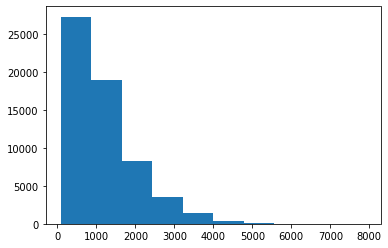

In [30]:
print(ssm_loc.min())
print(ssm_loc.argmin())
ssm_loc[ssm_loc<80] = 1000.
print(ssm_loc.min())
print(ssm_loc.argmin())
plt.hist(ssm_loc)

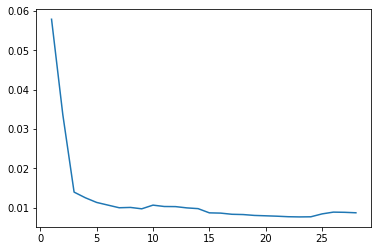

In [153]:
fig,ax = plt.subplots()
ax.plot(np.arange(1,29), np.mean(time_nk, axis=1))

In [41]:
j = ssm_loc.argmin() #4600

kd_latent = Tensor(test_kd_latent[j]).to(device).reshape((-1, nf, d, h, w))
log_K = decoder(kd_latent).reshape(6, 41, 81)

model.eval()

source = torch.zeros((1, 6, 41, 81,)).to(device)
y_prev = torch.zeros((1, 6, 41, 81)).to(device)
# obs = torch.zeros((len(Sy_ids)*len(Sx_ids), 10, 120)).to(device)

x = torch.zeros((1, 3, 6, 41, 81)).to(device)
x[:,0] = y_prev #this doesnt change time
x[:,1] = log_K #this doesnt change time
x[:,2] = source #this doesnt change time
y = model(x) #this doesnt change time, for 1 log_k, 0:len(Sy_ids)*len(Sx_ids):end
# fig = plot_3d_2(to_numpy(real_hk),to_numpy(log_K), 'head_only',cut=[3, 13+1, 20-1]) 
obs = to_numpy(
    y[:,1][:,sensor]
    )

del x,y,y_prev,kd_latent, source
torch.cuda.empty_cache()
np.sum((meas_data_6 - obs.reshape(-1))**2) ##[j*n_k + nkk]


91.63977339605191

(array([4.060e+03, 3.173e+03, 1.457e+03, 7.840e+02, 3.250e+02, 1.320e+02,
        5.000e+01, 1.300e+01, 2.000e+00, 4.000e+00]),
 array([  97.58402252,  778.83596741, 1460.0879123 , 2141.33985719,
        2822.59180208, 3503.84374697, 4185.09569186, 4866.34763675,
        5547.59958164, 6228.85152654, 6910.10347143]),
 <BarContainer object of 10 artists>)

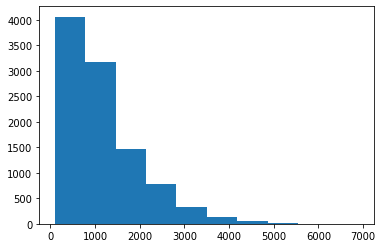

In [106]:
# for i in range(20):
fig,ax = plt.subplots()
ax.hist(ssm_loc)

In [12]:
def para_model_6(latent_z, n_k=1):
    latent_z = Tensor(latent_z).to(device).reshape(-1, nf, d, h, w)
    decoder.eval()
    log_K = decoder(latent_z).reshape(-1, 6, 41, 81)
    Sy_ids = [4, 20, 36]
    Sx_ids = [4, 20]#, 12，28]
    log_K = torch.vstack([log_K for i in range(len(Sy_ids)*len(Sx_ids))])
    model.eval()

    ## source rate
    source_rate = 300. #shape: 5,Ne
    source = torch.zeros((n_k*len(Sy_ids)*len(Sx_ids), 10, 6, 41, 81,)).to(device)
    ind = 0
    for Sy_id in Sy_ids:
        for Sx_id in Sx_ids: 
            # for j in range(5): #j'th timestep of release

            source[ind*n_k:(ind+1)*n_k, :5, 3, Sy_id, Sx_id] = source_rate
            ind += 1

    y_prev = torch.zeros((n_k*len(Sy_ids)*len(Sx_ids), 6, 41, 81)).to(device)
    obs = [[] for i in range(n_k)]
    # obs = torch.zeros((len(Sy_ids)*len(Sx_ids), 10, 120)).to(device)

    for t in range(10):
        x = torch.zeros((n_k*len(Sy_ids)*len(Sx_ids), 3, 6, 41, 81)).to(device)
        x[:,0] = y_prev #this doesnt change time
        x[:,1] = log_K #this doesnt change time
        x[:,2] = source[:,t] #this doesnt change time
        y = model(x) #this doesnt change time, for 1 log_k, 0:len(Sy_ids)*len(Sx_ids):end
        for i in range(n_k):

            # obs[i].append(to_numpy(
            #     y[i*len(Sy_ids)*len(Sx_ids):(i+1)*len(Sy_ids)*len(Sx_ids),0][:,sensor]
            #     )
            # )
            obs[i].append(to_numpy(
                y[ind_source[i],0][:,sensor]
                )
            )
            if t == 9:
                # obs[i].append(to_numpy(
                #     y[i*len(Sy_ids)*len(Sx_ids):(i+1)*len(Sy_ids)*len(Sx_ids),1][:,sensor]
                #     )
                # )
                obs[i].append(to_numpy(
                    y[ind_source[i],1][:,sensor]
                    )
                )              
     
        y_prev = y[:,0]
    del x,y,latent_z,log_K,y_prev
    torch.cuda.empty_cache()
    ssm_nk = np.zeros(n_k)
    for i in range(n_k):
        obs[i] = np.stack(obs[i]).reshape(-1)
        # print(meas_data_6.shape)
        ssm_nk[i] = np.sum((obs[i]-meas_data_6.reshape(-1))**2)
    return ssm_nk


def para_model_30(param, n_k=5, n_s=6):
    latent_z = param[:924*n_k]
    latent_z = Tensor(latent_z).to(device).reshape(-1, nf, d, h, w)
    
    Sy_ids = param[924*n_k: 924*n_k+n_s]
    # print(Sy_ids)
    Sx_ids = param[924*n_k+n_s: 924*n_k+n_s*2]
    decoder.eval()
    log_K = decoder(latent_z).reshape(-1, 6, 41, 81)
    log_K = torch.vstack([log_K for i in range(n_s)])

    source_rate = Tensor(param[924*n_k+n_s*2:].reshape((n_s, n_k)))
    ## source rate
    source = torch.zeros((n_k*n_s, 10, 6, 41, 81,)).to(device)
    for i in range(n_s):
        source[i*n_k:(i+1)*n_k, :5, 3, int(Sy_ids[i]), int(Sx_ids[i])] = source_rate[i,]
    ## previous conc
    y_prev = torch.zeros((n_k*n_s, 6, 41, 81)).to(device)
    obs = [[] for i in range(n_k)]
    # obs = torch.zeros((len(Sy_ids)*len(Sx_ids), 10, 120)).to(device)
    model.eval()
    for t in range(10):
        x = torch.zeros((n_k*n_s, 3, 6, 41, 81)).to(device)
        x[:,0] = y_prev #this doesnt change time
        x[:,1] = log_K #this doesnt change time
        x[:,2] = source[:,t] #this doesnt change time
        y = model(x) #this doesnt change time, for 1 log_k, 0:len(Sy_ids)*len(Sx_ids):end
        for i in range(n_k):
            obs[i].append(to_numpy(
                y[ind_source[i],0][:,sensor]
                )
            )
            if t == 9:
                obs[i].append(to_numpy(
                    y[ind_source[i],1][:,sensor]
                    )
                )              
        y_prev = y[:,0]
    del x,y,latent_z,log_K,y_prev,source
    torch.cuda.empty_cache()
    ssm_nk = np.zeros((n_k, n_s))
    for i in range(n_k):
        obs[i] = np.stack(obs[i])
        for j in range(n_s):
            # print(obs[i].shape)
            ssm_nk[i,j] = np.sum((obs[i][:,j,:].reshape(-1)-meas_data_6.reshape(-1))**2)
    return ssm_nk.reshape(-1)


In [67]:
meas_data_6.shape

(120,)

In [ ]:
meas_data_6 = meas_data_6.reshape(11,6,120)
obs = obs.reshape(11,6,120)
vis_sensors_2(meas_data_6[:,0,:], obs[:,0,:], np.where(sensor), '')

## ESMDA for logk

In [213]:
# real_latent_z
mcmc_single(chain[-1,:], meas_data_6)

1.5930040399572378

In [204]:
from scipy import array, linalg, dot
import math
def mcmc_single(kd_latent, data):
    kd_latent = kd_latent.reshape(-1, nf, d, h, w)
    n_k = kd_latent.shape[0]
    kd_latent = Tensor(kd_latent).to(device)
    log_K = decoder(kd_latent).reshape(-1, 6, 41, 81)
    # if j == 0:
    #     log_K = Tensor(real_hk).to(device).reshape(-1,6,41,81) + Tensor(np.random.randn(6*41*81).reshape(-1,6,41,81))
    model.eval()

    source = torch.zeros((n_k, 6, 41, 81,)).to(device)
    y_prev = torch.zeros((n_k, 6, 41, 81)).to(device)
    # obs = torch.zeros((len(Sy_ids)*len(Sx_ids), 10, 120)).to(device)

    x = torch.zeros((n_k, 3, 6, 41, 81)).to(device)
    x[:,0] = y_prev #this doesnt change time
    x[:,1] = log_K #this doesnt change time
    x[:,2] = source #this doesnt change time
    y = model(x) #this doesnt change time, for 1 log_k, 0:len(Sy_ids)*len(Sx_ids):end

    obs = to_numpy(
        y[:,1][:,sensor]
        )

    del x,y,log_K,y_prev,kd_latent, source
    torch.cuda.empty_cache()
    ssm =  np.sum((meas_data_6.reshape(-1) - obs[0].reshape(-1))**2) ##[j*n_k + nkk]
    return ssm #(n_k, 120)

def forward_batch(kd_latent):
    kd_latent = kd_latent.reshape(-1, nf, d, h, w)
    n_k = kd_latent.shape[0]
    kd_latent = Tensor(kd_latent).to(device)
    log_K = decoder(kd_latent).reshape(-1, 6, 41, 81)
    # if j == 0:
    #     log_K = Tensor(real_hk).to(device).reshape(-1,6,41,81) + Tensor(np.random.randn(6*41*81).reshape(-1,6,41,81))
    model.eval()

    source = torch.zeros((n_k, 6, 41, 81,)).to(device)
    y_prev = torch.zeros((n_k, 6, 41, 81)).to(device)
    # obs = torch.zeros((len(Sy_ids)*len(Sx_ids), 10, 120)).to(device)

    x = torch.zeros((n_k, 3, 6, 41, 81)).to(device)
    x[:,0] = y_prev #this doesnt change time
    x[:,1] = log_K #this doesnt change time
    x[:,2] = source #this doesnt change time
    y = model(x) #this doesnt change time, for 1 log_k, 0:len(Sy_ids)*len(Sx_ids):end

    obs = to_numpy(
        y[:,1][:,sensor]
        )

    del x,y,log_K,y_prev,kd_latent, source
    torch.cuda.empty_cache()
    # for nkk in range(n_k):
    #     ssm_loc[j*n_k + nkk] = np.sum((meas_data_6 - obs[nkk].reshape(-1))**2) ##[j*n_k + nkk]
    return obs #(n_k, 120)
def ES_MDA(num_ens,m_ens,Z,prod_ens,alpha,CD,corr,numsave=2):
    # Z is the obs; prob_ens is the sim_obs; CD is the error
    # note that in this func, the shape of the array is (Num_nodes,Num_ens)
    varn=1-1/math.pow(10,numsave)
    # Initial Variavel 
    # Forecast step
    yf = m_ens.T                      # Non linear forward model, transform to (Num_nodes,Num_ens)
    df = prod_ens.T                   # Observation Model, transform to (Num_nodes,Num_ens)
    ym = np.array(yf.mean(axis=1))    # Mean of the y_f
    dm = np.array(df.mean(axis=1))    # Mean of the d_f
    ym=ym.reshape(ym.shape[0],1)    
    dm=dm.reshape(dm.shape[0],1)    
    dmf = yf - ym
    ddf = df - dm
    
    Cmd_f = (np.dot(dmf,ddf.T))/(num_ens-1);  # The cros-covariance matrix
    Cdd_f = (np.dot(ddf,ddf.T))/(num_ens-1);  # The auto covariance of predicted data
    
    # Perturb the vector of observations
    R = linalg.cholesky(CD,lower=True) #Matriz triangular inferior
    U = R.T   #Matriz R transposta
    p , ww =np.linalg.eig(CD)
    
    aux = np.repeat(Z,num_ens,axis=1)

    mean = 0*(Z.T)

    noise=np.random.multivariate_normal(mean[0], np.eye(len(Z)), num_ens).T
    d_obs = aux+math.sqrt(alpha)*np.dot(U,noise)  
    
    # Analysis step
    u, s, vh = linalg.svd(Cdd_f+alpha*CD); v = vh.T
    diagonal = s
    for i in range(len(diagonal)):
        if (sum(diagonal[0:i+1]))/(sum(diagonal)) > varn:
            diagonal = diagonal[0:i+1]
            break
    
    u=u[:,0:i+1]
    v=v[:,0:i+1]
    ss = np.diag(diagonal**(-1))
    K=np.dot(Cmd_f,(np.dot(np.dot(v,ss),(u.T))))
    # Use Kalman covariance
    if len(corr)>0:
        K = corr*K
        
    ya = yf + (np.dot(K,(d_obs-df)))
    m_ens = ya
    return m_ens.T # tranform back to (Num_ens,Num_nodes)

In [176]:
Na=20
Alpha=np.array([Na for _ in range(Na)])
#meas_data_6 #data
Num_obs = 120
meas_data_6 = meas_data_6.reshape((-1,1))
#meas_sig #meas_sig
meas_sig = np.ones(120)*0.01
R=np.diag(meas_sig)
ns = 924
ens_choices = [480, 960, 1440]
error = np.zeros((len(ens_choices), Na+1))
for i, Num_ens in enumerate(ens_choices):
    print(Num_ens)
    s=np.zeros((Num_ens,ns,Na+1))
    KS_ini = np.random.randn(Num_ens,ns)
    s[:,:,0]=KS_ini
    n_k = 24
    for t in range(len(Alpha)):
        sim_obs = np.zeros((Num_ens,Num_obs))
        for j in range(Num_ens//n_k):
            sim_obs[j*n_k:(j+1)*n_k,] = forward_batch(s[j*n_k:(j+1)*n_k,:,t]) # shape of sim_obs (Num_ens,Num_obs)
        # print('RMSE ite_'+str(t)+ ' : ', np.sqrt(np.mean((np.mean(sim_obs,axis=0)-meas_data_6.flatten())**2))) # not the exact RMSE definition
        error[i, t] = np.sqrt(np.mean((np.mean(sim_obs,axis=0)-meas_data_6.flatten())**2))
        s[:,:,t+1] = ES_MDA(Num_ens, s[:,:,t], meas_data_6, sim_obs, Alpha[t], R, [], 2)
        s_tem=s[:,:,t+1]
        # savemat('./s_tem' + str(t+1) + '.mat', {'s_tem':s_tem}) # save s for each step
    for j in range(Num_ens//n_k):
        sim_obs[j*n_k:(j+1)*n_k,] = forward_batch(s[j*n_k:(j+1)*n_k,:,-1]) # shape of sim_obs (Num_ens,Num_obs)
    # print('RMSE ite_', len(Alpha), ' : ', np.sqrt(np.mean((np.mean(sim_obs,axis=0)-meas_data_6.flatten())**2)))
    error[i, -1] = np.sqrt(np.mean((np.mean(sim_obs,axis=0)-meas_data_6.flatten())**2))
    # ##start from the best of the previous ensemble again, perturbe the ensemble with 0.1 random error.
    # error = np.sum((sim_obs-meas_data_6.flatten())**2, axis=1)
    # best_ind = error.argmin()
    # KS_ini = np.repeat(s[best_ind,:,-1].reshape((1,-1)), Num_ens, axis=0) + np.random.randn(Num_ens,ns)
    # s=np.zeros((Num_ens,ns,Na+1))
    # s[:,:,0]=KS_ini
    # n_k = 24
    # for t in range(len(Alpha)):
    #     sim_obs = np.zeros((Num_ens,Num_obs))
    #     for j in range(Num_ens//n_k):
    #         sim_obs[j*n_k:(j+1)*n_k,] = forward_batch(s[j*n_k:(j+1)*n_k,:,t]) # shape of sim_obs (Num_ens,Num_obs)
    #     print('RMSE ite_'+str(t)+ ' : ', np.sqrt(np.mean((np.mean(sim_obs,axis=0)-meas_data_6.flatten())**2))) # not the exact RMSE definition
    #     s[:,:,t+1] = ES_MDA(Num_ens, s[:,:,t], meas_data_6, sim_obs, Alpha[t], R, [], 2)
    #     s_tem=s[:,:,t+1]
    #     # savemat('./s_tem' + str(t+1) + '.mat', {'s_tem':s_tem}) # save s for each step
    # for j in range(Num_ens//n_k):
    #     sim_obs[j*n_k:(j+1)*n_k,] = forward_batch(s[j*n_k:(j+1)*n_k,:,-1]) # shape of sim_obs (Num_ens,Num_obs)
    # print('RMSE ite_', len(Alpha), ' : ', np.sqrt(np.mean((np.mean(sim_obs,axis=0)-meas_data_6.flatten())**2)))

# savemat('results_esmda.mat',{'s':s}) 

480
960
1440


(array([482., 567., 249.,  94.,  36.,   8.,   2.,   1.,   0.,   1.]),
 array([0.13928704, 0.23933342, 0.33937981, 0.43942619, 0.53947257,
        0.63951895, 0.73956534, 0.83961172, 0.9396581 , 1.03970448,
        1.13975087]),
 <BarContainer object of 10 artists>)

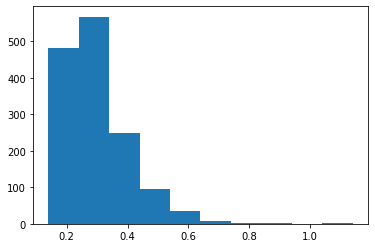

In [184]:
err = np.sqrt(np.mean((sim_obs-meas_data_6.flatten())**2, axis = 1))
plt.hist(err)

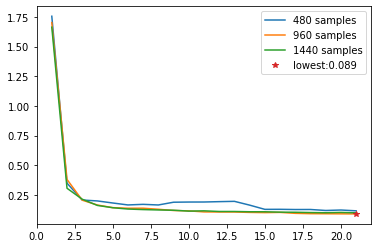

In [188]:
fig, ax = plt.subplots()
ite = np.arange(1, Na+2)
ax.plot(ite, error[0,:], label='480 samples')
ax.plot(ite, error[1,:], label='960 samples')
ax.plot(ite, error[2,:], label='1440 samples')
ax.plot(ite[-1], error.min(), '*', label='lowest:'+str(np.round(error.min(),3)))
ax.legend()

In [167]:
# (np.random.randn(Num_ens,ns)*0.2).shape
# np.repeat(np.mean(s[:,:,-1], axis=0).reshape((1,-1)), Num_ens, axis=0 )
error = np.sum((sim_obs-meas_data_6.flatten())**2, axis=1)
best_ind = error.argmin()
error.min()

3.2277380615591302

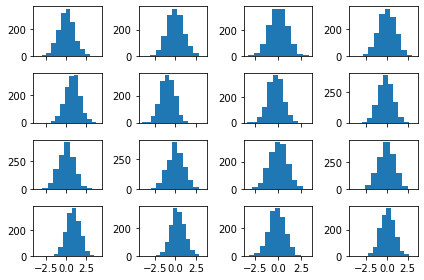

In [190]:
fig, axs = plt.subplots(4,4, sharex='col')
axs = axs.flat
ind = 0
dims = [10, 20, 40, 80, 500, 700, 800, 900]
for i in range(8):
    axs[ind].hist(s[:,dims[i],0])
    axs[ind+4].hist(s[:,dims[i],-1])
    if i==3:
        ind = 7
    ind += 1
plt.tight_layout()

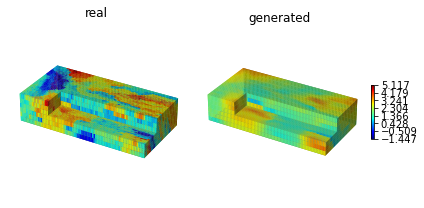

In [189]:
error = np.sum((sim_obs-meas_data_6.flatten())**2, axis=1)
# best_ind = error.argmin()
# end_latent = s[best_ind,:,-1]
end_latent = np.mean(s[:,:,-1], axis=0)
end_latent = end_latent.reshape((-1, nf, d, h, w))
best_logk = Tensor(end_latent).to(device)
decoder.eval()
best_logk = decoder(best_logk).reshape(6, 41, 81)
# real_log_K = decoder(real_kd_latent).reshape(6, 41, 81)
# fig = plot_3d_2(to_numpy(real_log_K),to_numpy(mean_log_K), 'diff_meas_sig')#,cut=[3, 13+1, 20-1])
fig = plot_3d_2(to_numpy(real_hk),to_numpy(best_logk), 'esmda_kd_mean',cut=[3, 13+1, 20-1]) 

## pymcmcstat


In [ ]:
pip install pymcmcstat

In [205]:
from pymcmcstat.MCMC import MCMC
mcstat = MCMC()
# initialize data structure
#x = sensor_i
#y = meas
end_latent = end_latent.reshape(-1)
mcstat.data.add_data_set(to_numpy(meas_sig), to_numpy(meas_data_6))
np.random.seed(88)
for i in range(924):
    mcstat.parameters.add_model_parameter(theta0 = end_latent[i], name='latent_'+str(i),minimum = -5, maximum = 5)

##simulation number
N = int(1e4)
mcstat.simulation_options.define_simulation_options(nsimu = N,\
                                                    updatesigma = 1 , 
                                                    # method = 'dram',
                                                    # method = 'mh',
                                                    method = 'dr',
                                                    # method = 'am',
                                                    adaptint = 100 , verbosity = 1.0 ,\
                                                    waitbar = 1, stats = 1)




Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
  latent_0:     -0.23 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_1:     -0.15 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_2:     -0.59 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_3:      0.03 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_4:     -0.07 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_5:      0.14 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_6:     -0.15 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_7:     -0.08 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_8:     -0.64 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_9:      0.10 [    -5.00,      5.00] N( 0.00e+00,      inf)
 latent_10:      0.74 [    -5.00,      5.00] N( 0.00e+00,      inf)
 latent_11:      0.32 [    -5.00,      5.00] N( 0.00e+00,      inf)
 latent_12:      0.14 [    -5.00,      5.00] N( 0.00e+00,      inf)
 latent_13:     -0.

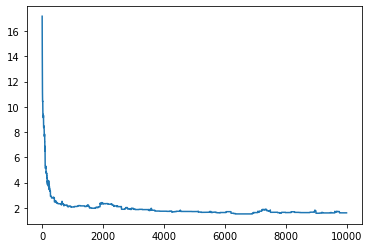

In [206]:
mcstat.model_settings.define_model_settings(sos_function = mcmc_single)

# Run mcmcrun
mcstat.run_simulation()
# Extract results
results = mcstat.simulation_results.results
chain = results['chain']
names = results['names']

#plots
# mcpl = mcstat.mcmcplot
# mcpl.plot_chain_panel(chain,names)

# define burnin
burnin = int(5e3)##int(N/3*2)
# display chain statistics
# generate mcmc plots
# mcpl = mcstat.mcmcplot # initialize plotting methods
# mcpl.plot_density_panel(chain[burnin:,:] , names)
# mcpl.plot_chain_panel(chain[burnin:,:] , names)
# mcpl.plot_pairwise_correlation_panel(chain[burnin:,:],names)
with open("/content/drive/MyDrive/react_inverse/ILUES/ESMDA-MCMC_results.pkl","wb") as f:
    pkl.dump(results,f)
print('saved samples')
plt.plot(results['sschain'])##dr

In [215]:
with open("/content/drive/MyDrive/react_inverse/ILUES/ESMDA-MCMC_results.pkl","wb") as f:
    pkl.dump(results,f)

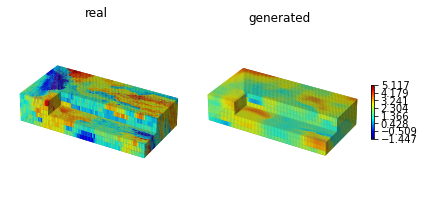

In [214]:
chain = results['chain']
names = results['names']
burnin = int(5e2)##int(N/3*2)
mean_logk = np.mean(chain[-1:,:924], axis=0)
mean_logk = mean_logk.reshape((-1, nf, d, h, w))
mean_logk = Tensor(mean_logk).to(device)
decoder.eval()
mean_log_K = decoder(mean_logk).reshape(6, 41, 81)
# real_log_K = decoder(real_kd_latent).reshape(6, 41, 81)
# fig = plot_3d_2(to_numpy(real_log_K),to_numpy(mean_log_K), 'diff_meas_sig')#,cut=[3, 13+1, 20-1])
fig = plot_3d_2(to_numpy(real_hk),to_numpy(mean_log_K), 'diff_meas_sig_esmda_mcmc',cut=[3, 13+1, 20-1])
# fig.savefig('/content/drive/MyDrive/react_inverse/ILUES/diff_kd_MCMC.pdf', format='pdf')

## kd only with 6 release


In [13]:
n_k = 5
N = 100000
n_s = 6
np.random.seed(888)
kd_latent = np.random.randn(924*N).reshape((-1, nf, d, h, w))
real_latent_z = encoder(Tensor(real_hk.reshape(-1,1,6,41,81)))
# kd_latent[0] = to_numpy(real_latent_z)
ind_source = []
for i in range(n_k):
    ind_source.append(list(np.arange(i,n_k*n_s,step=n_k)))
## record the best parameter set and the index, and the best ssm.
best_ssm = 10000.
best_arg = 0
best_param = None

start = time.time()
for i in tqdm(range(N//n_k)):
    Sy = np.random.choice([4, 12, 20, 28, 36], n_s)
    Sx = np.random.choice([4, 12, 20, 28], n_s)
    source_rate = np.random.uniform(100, 1000, size=(n_s, n_k))
    # Sy[0] = 20
    # Sx[0] = 12
    # source_rate[0,:] = 300.
    param = np.vstack(
        (kd_latent[i*(n_k):(i+1)*n_k].reshape(-1,1), 
        Sy.reshape(-1,1), Sx.reshape(-1,1), 
        source_rate.reshape(-1,1))
        ).reshape(-1)
    ssm = para_model_30(param, n_k, n_s)
    if ssm.min()<best_ssm:
        best_ssm = ssm.min()
        best_param = param
        best_arg = ssm.argmin()
print(time.time()-start)
print('best ssm:', best_ssm)

100%|██████████| 20000/20000 [7:08:49<00:00,  1.29s/it]

25729.976663827896
best ssm: 1356.5259294112948


12.0
28.0
[545.93552773 411.38922712 659.69981529 390.284407   911.60465105]


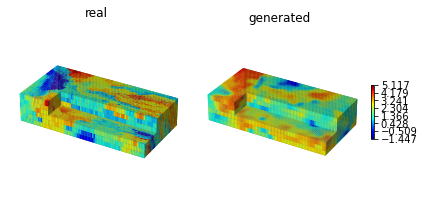

In [14]:
kd = best_param[:924*n_k].reshape((-1, nf, d, h, w))
Sy = best_param[924*n_k: 924*n_k+n_s] 
Sx = best_param[924*n_k+n_s: 924*n_k+n_s*2]
source_rate = best_param[924*n_k+n_s*2:].reshape((n_s, n_k))
print(Sy[best_arg // n_k])
print(Sx[best_arg // n_k])
print(source_rate[best_arg // n_k])

best_kd = kd[best_arg % n_k].reshape((-1, nf, d, h, w))
best_logk = Tensor(best_kd).to(device)
decoder.eval()
best_logk = decoder(best_logk).reshape(6, 41, 81)
# real_log_K = decoder(real_kd_latent).reshape(6, 41, 81)
# fig = plot_3d_2(to_numpy(real_log_K),to_numpy(mean_log_K), 'diff_meas_sig')#,cut=[3, 13+1, 20-1])
fig = plot_3d_2(to_numpy(real_hk),to_numpy(best_logk), '',cut=[3, 13+1, 20-1]) 

In [15]:
with open('/content/drive/MyDrive/react_inverse/ILUES/all_searching_1e5.pkl', 'wb') as file:
    pkl.dump([best_kd, best_arg, best_param, meas_data_6, real_hk], file)

In [16]:
print('done')

done


In [33]:
## random search, fixed and known release
N = 100000
n_k = 5
ssm = np.zeros(N)
np.random.seed(888)
kd_latent = np.random.randn(924*N).reshape((-1, nf, d, h, w))

start = time.time()
for i in range(N//n_k):
    ssm_nk = para_model_6(kd_latent[i*(n_k):(i+1)*n_k], n_k)
    ssm[i*(n_k):(i+1)*n_k] = ssm_nk

print(time.time()-start)
print(ssm.min())
print(ssm.argmin())

16024.273032426834
11649.931583362206
19783


In [37]:
with open('/content/drive/MyDrive/react_inverse/ILUES/grid_searching_1e5.pkl', 'wb') as file:
    pkl.dump([kd_latent, ssm, meas_data_6, real_hk], file)

In [38]:
with open('/content/drive/MyDrive/react_inverse/ILUES/good_start.pkl', 'wb') as file:
    pkl.dump([kd_latent[ssm.argmin()], ssm[ssm.argmin()], meas_data_6, real_hk], file)

(array([ 1.,  1.,  4.,  3.,  5., 15., 15., 15., 39., 41.]),
 array([11649.93158336, 12483.12682769, 13316.32207201, 14149.51731634,
        14982.71256066, 15815.90780499, 16649.10304932, 17482.29829364,
        18315.49353797, 19148.68878229, 19981.88402662]),
 <BarContainer object of 10 artists>)

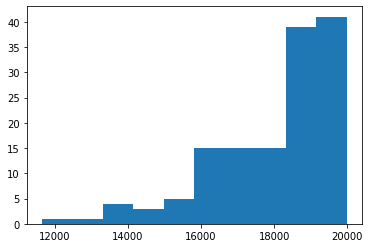

In [42]:
plt.hist(ssm[ssm<20000])

In [63]:
with open('/content/drive/MyDrive/react_inverse/ILUES/good_start.pkl', 'rb') as file:
    [good_start, good_ssm, meas_data_6, real_hk] = pkl.load(file)

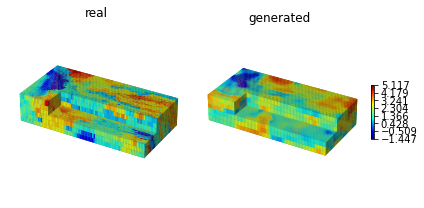

In [64]:
# N = 374
# np.random.seed(888)
# for i in range(N):
#     kd_latent = np.random.randn(924).reshape((-1, nf, d, h, w))
# obs = NN_model_6(kd_latent) 
# kd_latent[ssm.argmin()]  
mean_logk = good_start.reshape((-1, nf, d, h, w))
mean_logk = Tensor(mean_logk).to(device)
decoder.eval()
mean_log_K = decoder(mean_logk).reshape(6, 41, 81)
# real_log_K = decoder(real_kd_latent).reshape(6, 41, 81)
# fig = plot_3d_2(to_numpy(real_log_K),to_numpy(mean_log_K), 'diff_meas_sig')#,cut=[3, 13+1, 20-1])
fig = plot_3d_2(to_numpy(real_hk),to_numpy(mean_log_K), 'diff_meas_sig',cut=[3, 13+1, 20-1]) 

In [35]:
files.download('/content/diff_meas_sig.pdf') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(array([ 11.,  25.,  79., 159., 239., 224., 117.,  55.,  13.,   2.]),
 array([-3.0123065 , -2.3811283 , -1.7499499 , -1.1187717 , -0.4875934 ,
         0.14358485,  0.7747631 ,  1.4059414 ,  2.0371196 ,  2.6682978 ,
         3.2994761 ], dtype=float32),
 <BarContainer object of 10 artists>)

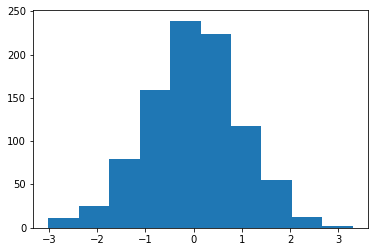

In [25]:
real_latent_z = encoder(Tensor(real_hk.reshape(-1,1,6,41,81)))
plt.hist(to_numpy(real_latent_z.reshape(-1)))

(array([  3.,  10.,  66., 142., 195., 223., 167.,  86.,  28.,   4.]),
 array([-3.3261476 , -2.6827505 , -2.0393534 , -1.3959562 , -0.752559  ,
        -0.10916185,  0.5342353 ,  1.1776325 ,  1.8210295 ,  2.4644268 ,
         3.1078238 ], dtype=float32),
 <BarContainer object of 10 artists>)

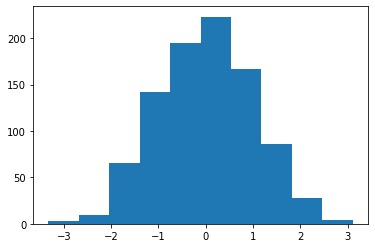

In [40]:
# plt.hist(ssm[ssm<1000])
plt.hist(to_numpy(mean_logk.reshape(-1)))

In [57]:

def para_model_6(latent_z,data):
    n_k = 1
    latent_z = Tensor(latent_z).to(device).reshape(-1, nf, d, h, w)
    decoder.eval()
    log_K = decoder(latent_z).reshape(-1, 6, 41, 81)
    Sy_ids = [4, 20, 36]
    Sx_ids = [4, 20]#, 12，28]
    log_K = torch.vstack([log_K for i in range(len(Sy_ids)*len(Sx_ids))])
    model.eval()

    ## source rate
    source_rate = 300. #shape: 5,Ne
    source = torch.zeros((n_k*len(Sy_ids)*len(Sx_ids), 10, 6, 41, 81,)).to(device)
    ind = 0
    for Sy_id in Sy_ids:
        for Sx_id in Sx_ids: 
            # for j in range(5): #j'th timestep of release

            source[ind*n_k:(ind+1)*n_k, :5, 3, Sy_id, Sx_id] = source_rate
            ind += 1

    y_prev = torch.zeros((n_k*len(Sy_ids)*len(Sx_ids), 6, 41, 81)).to(device)
    obs = [[] for i in range(n_k)]
    # obs = torch.zeros((len(Sy_ids)*len(Sx_ids), 10, 120)).to(device)

    for t in range(10):
        x = torch.zeros((n_k*len(Sy_ids)*len(Sx_ids), 3, 6, 41, 81)).to(device)
        x[:,0] = y_prev #this doesnt change time
        x[:,1] = log_K #this doesnt change time
        x[:,2] = source[:,t] #this doesnt change time
        y = model(x) #this doesnt change time, for 1 log_k, 0:len(Sy_ids)*len(Sx_ids):end
        for i in range(n_k):

            # obs[i].append(to_numpy(
            #     y[i*len(Sy_ids)*len(Sx_ids):(i+1)*len(Sy_ids)*len(Sx_ids),0][:,sensor]
            #     )
            # )
            obs[i].append(to_numpy(
                y[ind_source[i],0][:,sensor]
                )
            )
            if t == 9:
                # obs[i].append(to_numpy(
                #     y[i*len(Sy_ids)*len(Sx_ids):(i+1)*len(Sy_ids)*len(Sx_ids),1][:,sensor]
                #     )
                # )
                obs[i].append(to_numpy(
                    y[ind_source[i],1][:,sensor]
                    )
                )              
     
        y_prev = y[:,0]
    del x,y,latent_z,log_K,y_prev
    torch.cuda.empty_cache()
    ssm_nk = np.zeros(n_k)
    for i in range(n_k):
        obs[i] = np.stack(obs[i]).reshape(-1)
        # print(meas_data_6.shape)
        ssm_nk[i] = np.sum((obs[i]-meas_data_6.reshape(-1))**2)
    return ssm_nk

In [77]:
from pymcmcstat.MCMC import MCMC
mcstat = MCMC()
# initialize data structure
#x = sensor_i
#y = meas
good_start = good_start.reshape(-1)
mcstat.data.add_data_set(to_numpy(meas_sig), to_numpy(meas_data_6))
np.random.seed(88)
for i in range(924):
    mcstat.parameters.add_model_parameter(theta0 = good_start[i], name='latent_'+str(i),minimum = -5, maximum = 5)

##simulation number
N = int(1e4)
mcstat.simulation_options.define_simulation_options(nsimu = N,\
                                                    updatesigma = 1 , 
                                                    # method = 'dram',
                                                    # method = 'mh',
                                                    method = 'dr',
                                                    # method = 'am',
                                                    adaptint = 100 , verbosity = 1.0 ,\
                                                    waitbar = 1, stats = 1)

In [78]:
mcstat.model_settings.define_model_settings(sos_function = para_model_6)

# Run mcmcrun
mcstat.run_simulation()
# Extract results
results = mcstat.simulation_results.results
chain = results['chain']
names = results['names']

#plots
# mcpl = mcstat.mcmcplot
# mcpl.plot_chain_panel(chain,names)

# define burnin
burnin = int(5e3)##int(N/3*2)
# display chain statistics
# generate mcmc plots
# mcpl = mcstat.mcmcplot # initialize plotting methods
# mcpl.plot_density_panel(chain[burnin:,:] , names)
# mcpl.plot_chain_panel(chain[burnin:,:] , names)
# mcpl.plot_pairwise_correlation_panel(chain[burnin:,:],names)
with open("/content/drive/MyDrive/react_inverse/ILUES/6_NNMCMC_results.pkl","wb") as f:
    pkl.dump(results,f)
print('saved samples')


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
  latent_0:     -0.23 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_1:     -0.08 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_2:      1.14 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_3:     -0.42 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_4:      1.27 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_5:     -0.58 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_6:      2.12 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_7:     -0.90 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_8:      1.27 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_9:     -0.72 [    -5.00,      5.00] N( 0.00e+00,      inf)
 latent_10:      1.50 [    -5.00,      5.00] N( 0.00e+00,      inf)
 latent_11:     -0.05 [    -5.00,      5.00] N( 0.00e+00,      inf)
 latent_12:     -1.84 [    -5.00,      5.00] N( 0.00e+00,      inf)
 latent_13:      1.

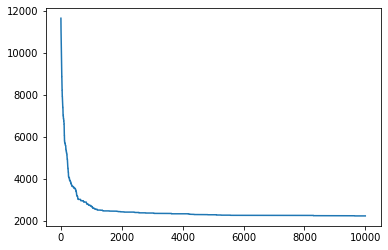

In [79]:
plt.plot(results['sschain'])##dr

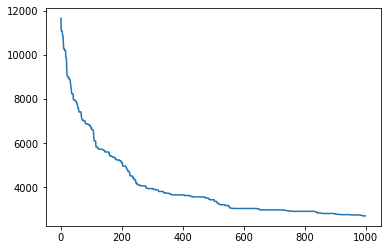

In [67]:
# plt.plot(results['sschain'])##dr

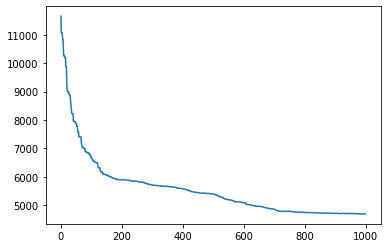

In [71]:
# plt.plot(results['sschain'])##dram

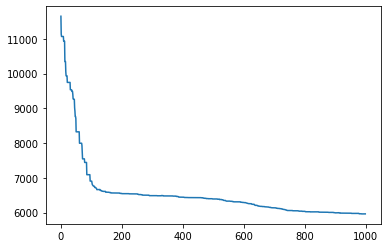

In [74]:
# plt.plot(results['sschain'])##am

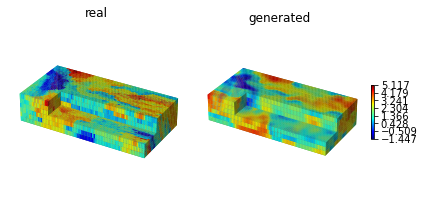

In [87]:
chain = results['chain']
names = results['names']
burnin = int(5e2)##int(N/3*2)
mean_logk = np.mean(chain[-10:,:924], axis=0)
mean_logk = mean_logk.reshape((-1, nf, d, h, w))
mean_logk = Tensor(mean_logk).to(device)
decoder.eval()
mean_log_K = decoder(mean_logk).reshape(6, 41, 81)
# real_log_K = decoder(real_kd_latent).reshape(6, 41, 81)
# fig = plot_3d_2(to_numpy(real_log_K),to_numpy(mean_log_K), 'diff_meas_sig')#,cut=[3, 13+1, 20-1])
fig = plot_3d_2(to_numpy(real_hk),to_numpy(mean_log_K), 'diff_meas_sig_mcmc',cut=[3, 13+1, 20-1])
# fig.savefig('/content/drive/MyDrive/react_inverse/ILUES/diff_kd_MCMC.pdf', format='pdf')

In [88]:
files.download('/content/diff_meas_sig_mcmc.pdf') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## kd and source

In [244]:
import pymcmcstat
print(pymcmcstat.__version__)

1.9.1


In [262]:
from pymcmcstat.MCMC import MCMC
mcstat = MCMC()
# initialize data structure
#x = sensor_i
#y = meas
mcstat.data.add_data_set(to_numpy(meas_sig), to_numpy(meas_data))
np.random.seed(88)
for i in range(924):
    mcstat.parameters.add_model_parameter(theta0 = np.random.randn(), name='latent_'+str(i),minimum = -5, maximum = 5)

mcstat.parameters.add_model_parameter(theta0 = np.random.randint(0, high=41), name='sy_ind',minimum = 0, maximum = 40)
mcstat.parameters.add_model_parameter(theta0 = np.random.randint(0, high=29), name='sx_ind' ,minimum = 0, maximum = 28)

for i in range(5):
    mcstat.parameters.add_model_parameter(theta0 = np.random.randint(0, high=1000), name='source_'+str(i+1) ,minimum = 0, maximum = 1000)

##simulation number
N = int(1e3)
mcstat.simulation_options.define_simulation_options(nsimu = N,\
                                                    updatesigma = 1 , method = 'dram',\
                                                    adaptint = 100 , verbosity = 1.0 ,\
                                                    waitbar = 1, stats = 1)

In [263]:
mcstat.model_settings.define_model_settings(sos_function = test_ssfun)

# Run mcmcrun
mcstat.run_simulation()
# Extract results
results = mcstat.simulation_results.results
chain = results['chain']
names = results['names']

#plots
# mcpl = mcstat.mcmcplot
# mcpl.plot_chain_panel(chain,names)

# define burnin
burnin = int(5e2)##int(N/3*2)
# display chain statistics
# generate mcmc plots
# mcpl = mcstat.mcmcplot # initialize plotting methods
# mcpl.plot_density_panel(chain[burnin:,:] , names)
# mcpl.plot_chain_panel(chain[burnin:,:] , names)
# mcpl.plot_pairwise_correlation_panel(chain[burnin:,:],names)
# with open("/content/drive/MyDrive/react_inverse/ILUES/6_NNMCMC_results.pkl","wb") as f:
#     pkl.dump(results,f)
print('saved samples')


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
  latent_0:      0.11 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_1:      2.21 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_2:      0.96 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_3:      0.07 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_4:      1.07 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_5:      1.00 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_6:     -0.93 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_7:      0.73 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_8:     -0.17 [    -5.00,      5.00] N( 0.00e+00,      inf)
  latent_9:     -1.29 [    -5.00,      5.00] N( 0.00e+00,      inf)
 latent_10:      1.06 [    -5.00,      5.00] N( 0.00e+00,      inf)
 latent_11:     -0.04 [    -5.00,      5.00] N( 0.00e+00,      inf)
 latent_12:     -0.90 [    -5.00,      5.00] N( 0.00e+00,      inf)
 latent_13:     -1.

In [14]:
# with open("/content/drive/MyDrive/react_inverse/ILUES/6_NNMCMC_results.pkl","rb") as f:
#     results = pkl.load(f)

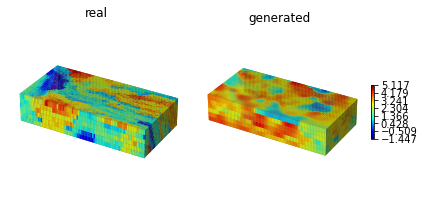

In [264]:
chain = results['chain']
names = results['names']
burnin = int(5e2)##int(N/3*2)
mean_logk = np.mean(chain[-10:,:924], axis=0)
mean_logk = mean_logk.reshape((-1, nf, d, h, w))
mean_logk = Tensor(mean_logk).to(device)
decoder.eval()
mean_log_K = decoder(mean_logk).reshape(6, 41, 81)
# real_log_K = decoder(real_kd_latent).reshape(6, 41, 81)
# fig = plot_3d_2(to_numpy(real_log_K),to_numpy(mean_log_K), 'diff_meas_sig')#,cut=[3, 13+1, 20-1])
fig = plot_3d_2(to_numpy(real_hk),to_numpy(mean_log_K), 'diff_meas_sig')#,cut=[3, 13+1, 20-1])
# fig.savefig('/content/drive/MyDrive/react_inverse/ILUES/diff_kd_MCMC.pdf', format='pdf')

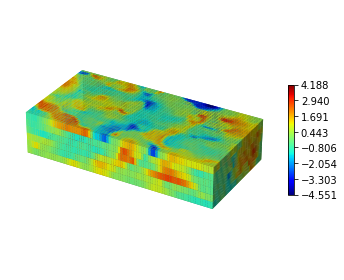

In [286]:
mean_logk = chain[0,:924]
mean_logk = mean_logk.reshape((-1, nf, d, h, w))
mean_logk = Tensor(mean_logk).to(device)
decoder.eval()
mean_log_K1 = decoder(mean_logk).reshape(6, 41, 81)

mean_logk = chain[-1,:924]
mean_logk = mean_logk.reshape((-1, nf, d, h, w))
mean_logk = Tensor(mean_logk).to(device)
decoder.eval()
mean_log_K2 = decoder(mean_logk).reshape(6, 41, 81)
# real_log_K = decoder(real_kd_latent).reshape(6, 41, 81)
# fig = plot_3d_2(to_numpy(real_log_K),to_numpy(mean_log_K), 'diff_meas_sig')#,cut=[3, 13+1, 20-1])
fig = plot_3d(to_numpy(mean_log_K1)-to_numpy(mean_log_K2), 'diff_meas_sig')#,cut=[3, 13+1, 20-1])

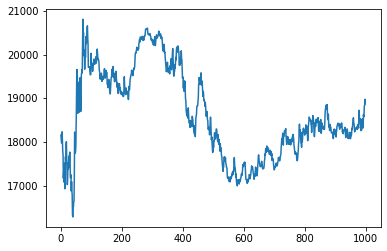

In [280]:
plt.plot(results['sschain'])

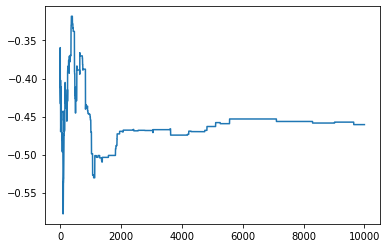

In [85]:
plt.plot(chain[:,923])

In [260]:
obs = NN_model(chain[-1,:])
np.sum((obs.reshape(-1)- meas_data.reshape(-1))**2)
# vis_sensors_2(to_numpy(meas_data).reshape((11, 120)), to_numpy(obs).reshape((11,120)), np.where(sensor), '')

2387.9317121152067

In [31]:
real_latent_z = encoder(Tensor(real_hk.reshape(-1,1,6,41,81)))
# reconst_logk = decoder(real_latent_z).reshape(6,41,81)
# obs = NN_model_6(real_latent_z)
# vis_sensors_2(to_numpy(meas_data).reshape((11, 120)), to_numpy(obs).reshape((11,120)), np.where(sensor), '')
# np.sum((obs.reshape(-1)- meas_data.reshape(-1))**2)

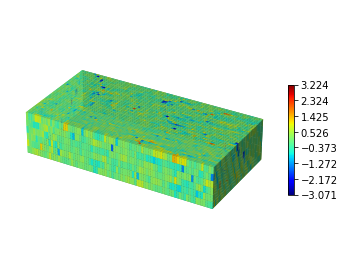

In [259]:
# fig = plot_3d_2(to_numpy(real_hk), to_numpy(reconst_logk),'')
fig = plot_3d(to_numpy(real_hk)-to_numpy(reconst_logk),'')

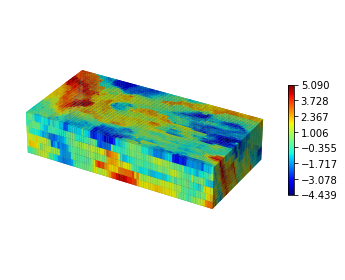

In [121]:
fig = plot_3d(to_numpy(mean_log_K) - to_numpy(real_hk),'abs error')
# fig.savefig('/content/drive/MyDrive/react_inverse/ILUES/error.pdf', format='pdf')

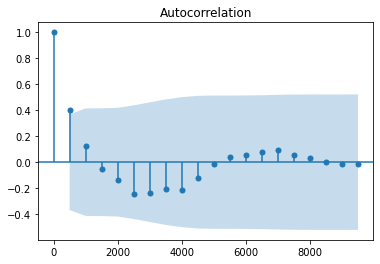

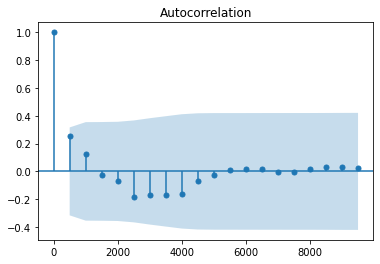

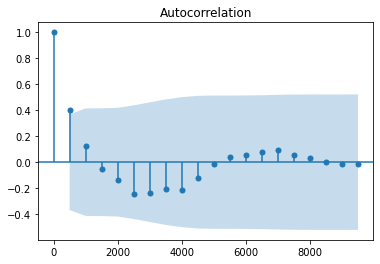

In [86]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(chain[:,0], lags=np.arange(0,N,N//20), fft = True,use_vlines=True)
sm.graphics.tsa.plot_acf(chain[:,100], lags=np.arange(0,N,N//20), fft = True,use_vlines=True)

In [ ]:
results.keys()

## pyro

In [ ]:
pip install pyro-ppl

     |████████████████████████████████| 634kB 2.9MB/s 


In [ ]:
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

import math
import torch.distributions.constraints as constraints

import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS, HMC
import logging
from pyro.infer.mcmc.util import diagnostics, initialize_model, print_summary

In [ ]:
mcmc = None
pyro.clear_param_store()
torch.cuda.empty_cache()

In [ ]:
nuts_kernel = NUTS(conditioned_model, step_size=1e-5)
# HMC_kernel = HMC(conditioned_model, full_mass=True,step_size=1e-4, num_steps=10)
mcmc = MCMC(
    nuts_kernel,
    # HMC_kernel,
    num_samples= 500,
    warmup_steps= 100,
    num_chains= 1
    )
mcmc.run(full_model, meas_data)

In [ ]:
mcmc.diagnostics()

In [ ]:
sams = mcmc.get_samples()

In [ ]:
mean_latent = sams['kd_latent'][-1:].mean(dim=0).reshape((-1, nf, d, h, w))
mean_latent = mean_latent.to(device)
decoder.eval()
mean_log_K = decoder(mean_latent).reshape(6, 41, 81)
# real_log_K = decoder(real_kd_latent).reshape(6, 41, 81)
fig = plot_3d_2(to_numpy(real_log_K),to_numpy(mean_log_K), 'diff_meas_sig')

In [ ]:
real_kd_latent.reshape((-1, ))

In [ ]:
sams = mcmc.get_samples()
with open('/content/drive/MyDrive/react_inverse/ILUES/hmc_samples','wb') as file:
  pkl.dump(sams, file)

In [ ]:
# loc = torch.zeros(924).to(device)
# scale = torch.ones(924).to(device)
# kd_latent = pyro.sample("kd_latent", pyro.distributions.Normal(loc, scale)).reshape((-1, nf, d, h, w))
# decoder.eval()
# kd_latent = kd_latent.to(device)
# log_K = decoder(kd_latent).reshape(6, 41, 81)
log_K = Tensor(real_hk).to(device)
## source loc
Sy_id, Sx_id = 12, 20
## source rate
source_rate = 100. #shape: 5,Ne
source = torch.zeros((10, 6, 41, 81,)).to(device)
for j in range(5): #j'th timestep of release
    source[j, 3, Sy_id, Sx_id] = source_rate

model.eval()

x0 = torch.stack(
    (torch.zeros((6, 41, 81)).to(device),
    log_K,
    source[0],)
).reshape(-1, 3, 6, 41, 81)
y0 = model(x0)

obs = torch.reshape(y_pred[:, sensor].clone(),(-1,)).to(device)

In [ ]:
meas_data.shape

(11, 120)

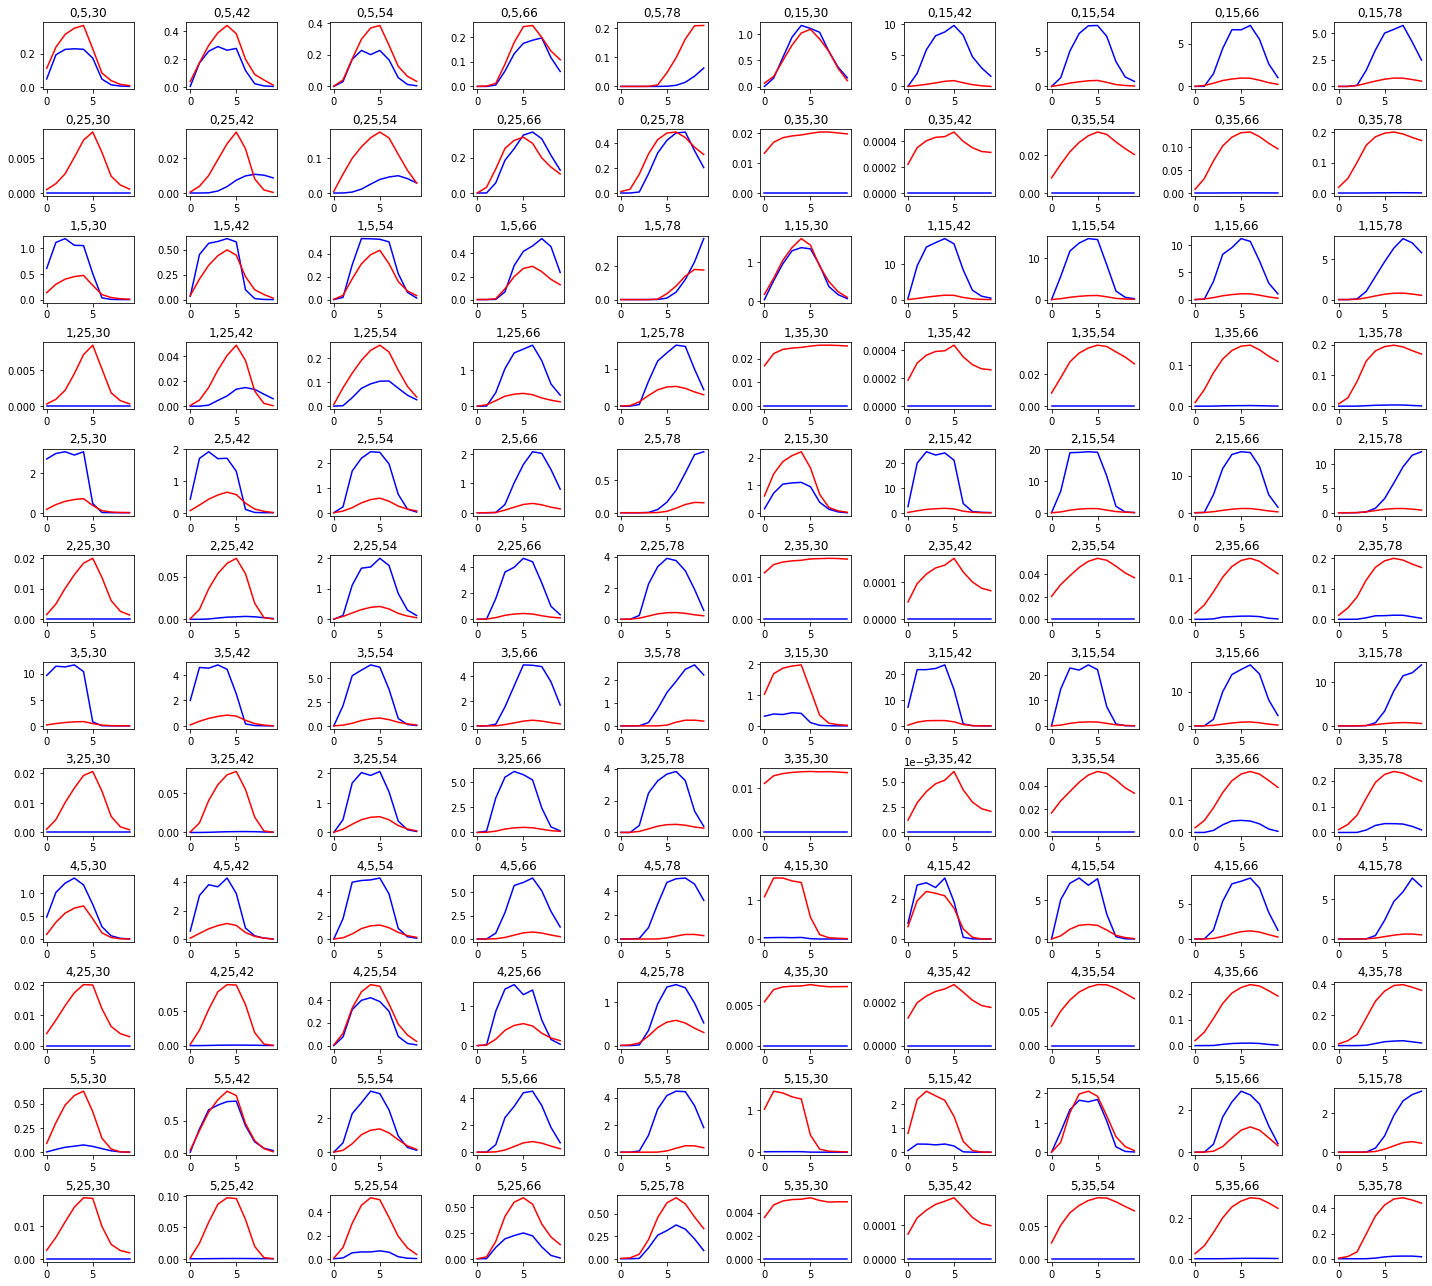

In [ ]:
vis_sensors_2(meas_data, np.reshape(obs.cpu().detach().numpy(), meas_data.shape), np.where(sensor), '')


## numpyro


In [ ]:
pip install --upgrade jax jaxlib

Requirement already up-to-date: jax in /usr/local/lib/python3.7/dist-packages (0.2.13)
     |████████████████████████████████| 45.3MB 117kB/s 
  Found existing installation: jaxlib 0.1.66+cuda110
    Uninstalling jaxlib-0.1.66+cuda110:
      Successfully uninstalled jaxlib-0.1.66+cuda110


In [ ]:
pip install --upgrade jax==0.2.10 jaxlib==0.1.62+cuda110 -f https://storage.googleapis.com/jax-releases/jax_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
Processing /root/.cache/pip/wheels/44/ea/ac/3be3bc19ee3b62f6fe1561eb6df1199284bb6bab819c1befa4/jax-0.2.10-cp37-none-any.whl
Requirement already up-to-date: jaxlib==0.1.62+cuda110 in /usr/local/lib/python3.7/dist-packages (0.1.62+cuda110)
  Found existing installation: jax 0.2.13
    Uninstalling jax-0.2.13:
      Successfully uninstalled jax-0.2.13


In [ ]:
pip install numpyro

In [ ]:
import matplotlib.pyplot as plt

from jax import random
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import COVTYPE, load_dataset
from numpyro.infer import HMC, HMCECS, MCMC, NUTS, SA, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoBNAFNormal
from numpyro.infer.reparam import NeuTraReparam

In [ ]:
from collections import namedtuple
from jax import random
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC

MHState = namedtuple("MHState", ["u", "rng_key"])

class MetropolisHastings(numpyro.infer.mcmc.MCMCKernel):
     sample_field = "u"

     def __init__(self, potential_fn, step_size=0.1):
         self.potential_fn = potential_fn
         self.step_size = step_size

     def init(self, rng_key, num_warmup, init_params, model_args, model_kwargs):
         return MHState(init_params, rng_key)

     def sample(self, state, model_args, model_kwargs):
         u, rng_key = state
         rng_key, key_proposal, key_accept = random.split(rng_key, 3)
         u_proposal = dist.Normal(u, self.step_size).sample(key_proposal)
         accept_prob = jnp.exp(self.potential_fn(u) - self.potential_fn(u_proposal))
         u_new = jnp.where(dist.Uniform().sample(key_accept) < accept_prob, u_proposal, u)
         return MHState(u_new, rng_key)

def f(x):
    x = torch.tensor(x)
    y = ((x - 2) ** 2).sum()
    y = y.detach().numpy()
    return y

kernel = MetropolisHastings(f)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000)
mcmc.run(random.PRNGKey(0), init_params=jnp.array([1., 2.]))
samples = mcmc.get_samples()
mcmc.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]


TypeError: ignored

## hamiltorch

In [ ]:
pip install git+https://github.com/AdamCobb/hamiltorch

  Cloning https://github.com/AdamCobb/hamiltorch to /tmp/pip-req-build-flnstuky
  Running command git clone -q https://github.com/AdamCobb/hamiltorch /tmp/pip-req-build-flnstuky
ERROR: Operation cancelled by user


In [ ]:
import hamiltorch
import time
print(hamiltorch.__version__)

In [ ]:
##example of hamiltorch
import torch
import hamiltorch
import matplotlib.pyplot as plt
import numpy as np

hamiltorch.set_random_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def log_prob(para):
    perm = generate_perm(para[:9])
    flux = generate_flux(para[9])
    init_temp = generate_temp(para[10])
    bo = generate_bo()
    li = generate_li()
    pressure = torch.ones((30, 10, 10))
    input = 



    mean = torch.tensor([0.,0.,0.])
    stddev = torch.tensor([.5,1.,2.]) 
    return torch.distributions.MultivariateNormal(mean, torch.diag(stddev**2)).log_prob(omega).sum()


In [ ]:

# HMC NUTS
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3) + 5
burn=500
N_nuts = burn + N
start = time.time()
params_hmc_nuts = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init,
                                                  num_samples=N_nuts,step_size=step_size,num_steps_per_sample=L,
                                                  sampler=hamiltorch.Sampler.HMC_NUTS, burn=burn,
                                                  desired_accept_rate=0.8)
print('time', time.time()-start)

## pymc3

In [ ]:
import pandas as pd
import pymc3 as pm
import arviz as az
from matplotlib import cm, gridspec
from matplotlib import pyplot as plt

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [ ]:
def get_obs(kd_latent, source, model, decoder, sensor):
    decoder.eval()
    kd_latent = kd_latent.to(device)
    log_K = decoder(kd_latent).reshape(6, 41, 81)
    model.eval()
    x0 = torch.stack(
        (torch.zeros((6, 41, 81)).to(device),
        log_K,
        source[0],)
    ).reshape(-1, 3, 6, 41, 81)
    y0 = model(x0)

    x1 = torch.stack(
        (y0[0,0],
        log_K,
        source[1],)
    ).reshape(-1, 3, 6, 41, 81)
    y1 = model(x1)

    x2 = torch.stack(
        (y1[0,0],
        log_K,
        source[2])
    ).reshape(-1, 3, 6, 41, 81)
    y2 = model(x2)

    x3 = torch.stack(
        (y2[0,0],
        log_K,
        source[3])
    ).reshape(-1, 3, 6, 41, 81)
    y3 = model(x3)

    x4 = torch.stack(
        (y3[0,0],
        log_K,
        source[4])
    ).reshape(-1, 3, 6, 41, 81)
    y4 = model(x4)

    x5 = torch.stack(
        (y4[0,0],
        log_K,
        source[5])
    ).reshape(-1, 3, 6, 41, 81)
    y5 = model(x5)

    x6 = torch.stack(
        (y5[0,0],
        log_K,
        source[6])
    ).reshape(-1, 3, 6, 41, 81)
    y6 = model(x6)

    x7 = torch.stack(
        (y6[0,0],
        log_K,
        source[7])
    ).reshape(-1, 3, 6, 41, 81)
    y7 = model(x7)

    x8 = torch.stack(
        (y7[0,0],
        log_K,
        source[8])
    ).reshape(-1, 3, 6, 41, 81)
    y8 = model(x8)

    x9 = torch.stack(
        (y8[0,0],
        log_K,
        source[9])
    ).reshape(-1, 3, 6, 41, 81)
    y9 = model(x9)

    y_pred = torch.stack((
        y0[0,0], y1[0,0], y2[0,0], y3[0,0], y4[0,0],
        y5[0,0], y6[0,0], y7[0,0], y8[0,0], y9[0,0],
        y0[0,1]
    )).to(device)
    obs = torch.reshape(y_pred[:, sensor].clone(),(-1,)).to(device)
    meas_sig = 0.05
    loglike = -0.5 * torch.sum((obs - meas_data) ** 2 * torch.exp(-2 * self.logs) + 2 * self.logs)
    return loglike



In [ ]:
with open('/content/drive/MyDrive/react_inverse/ILUES/HMC_meas.pkl','rb') as file:
    [real_kd_latent, log_K, meas_data] = pkl.load(file)

In [ ]:
basic_model = pm.Model()

with basic_model:
    latent_z = pm.Normal("latent_z", mu=np.zeros(924), sigma=np.ones(924), shape=924)
    latent_z = tt.as_tensor_variable(latent_z)
    # latent_z = latent_z.to(device)
    log_K = decoder(latent_z).reshape(6, 41, 81)

In [ ]:
import theano.tensor as tt
import torch 
import numpy as np
import theano

class bp(tt.Op):
    '''
        Theano.Op for backward pass used for `fp` op.
        Do not use it explicitly in your graphs. 
    '''
    def __init__(self, net, debug, dtype):
        self.net= net
        
        self.output_   = None
        self.input_    = None
        self.input_np_ = None
        
        self.debug = debug
        self.dtype = dtype
        
    __props__ = ()
 
    def make_node(self, x, y):
        x_ = tt.as_tensor_variable(x)
        y_ = tt.as_tensor_variable(y)
        return theano.gof.Apply(self, [x_, y_], [x_.type()])
 
    def perform(self, node, inputs, output_storage): 
        '''
            Actual backward pass computations. 
            We will do some kind of caching:
                Check if the input is the same as the stored one during forward pass 
                If it is the same -- do only backward pass, if it is different do forward pass again here
        '''
        
        input = inputs[0]
        grad_output = inputs[1]

        if self.debug: print('Backward pass:')

        # Caching
        if self.input_np_ is not None:
            if np.all(np.allclose(inputs[0], self.input_np_)):
                # assume np.all(np.allclose(output_var.data.cpu().numpy(), self.output_.data.cpu().numpy()))
                
                output_var = self.output_
                input_var = self.input_
                
                if self.debug: print('\t1)Forward in backward: cached')
            else:
                assert False, 'Buffer does not match input, IT\'s A BUG'
        else:
            
            input_var = torch.autograd.Variable(torch.from_numpy(input).type(self.dtype), requires_grad=True)
            output_var = self.net(input_var)
            
            if self.debug: print('\t1)Forward in backward: compute')
                
        
        if self.debug: print('\t2) Backward in backward')
        
        # Backward
        grad = torch.from_numpy(grad_output).type(self.dtype)
        output_var.backward(gradient = grad)
            
        # Put result in the right place
        output_storage[0][0] = input_var.grad.data.cpu().numpy().astype(inputs[0].dtype)

    def grad(self, inputs, output_grads):
        assert False, 'We should never get here'
        return [output_grads[0]]
 
    def __str__(self):
        return 'backward_pass'

class pytorch_wrapper(tt.Op):
    '''
        This is a theano.Op that can evaluate network from pytorch
        And get its gradient w.r.t. input 
    '''
    def __init__(self, net, debug=False, dtype=torch.FloatTensor):
        self.net = net.type(dtype)
        self.dtype = dtype
        
        self.bpop = bp(self.net, debug, dtype) 
        self.debug = debug
    __props__ = ()
 
    def make_node(self, x):
        x_ = tt.as_tensor_variable(x)
        return theano.gof.Apply(self, [x_], [x_.type()])
 
    def perform(self, node, inputs, output_storage):
        '''
            In this function we should compute output tensor
            Inputs are numpy array, so it's easy
        '''
        if self.debug: print('Forward pass')
        
        # Wrap input into variable
        input = torch.autograd.Variable(torch.from_numpy(inputs[0]).type(self.dtype), requires_grad=True)
        out = self.net(input)
        out_np = out.data.cpu().numpy().astype(inputs[0].dtype)
        
        # Put output to the right place 
        output_storage[0][0] = out_np
        
        
        self.bpop.output_ = out
        self.bpop.input_ = input
        self.bpop.input_np_ = inputs[0]
     
    def grad(self, inputs, output_grads):
        '''
            And `grad` should operate TheanoOps only, not numpy arrays
            So the only workaround I've found is to define another TheanoOp for backward pass and call it
        '''
        return [self.bpop(inputs[0], output_grads[0])]

    def __str__(self):
        return 'forward_pass'

In [ ]:
import theano
import theano.tensor as tt
import torch 
import numpy as np
class LinearModel(torch.nn.Module):
    
    def __init__(self):
        super(LinearModel, self).__init__()
        
        self.m = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.float64))
        self.b = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.float64))
        self.logs = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.float64))
        
    def forward(self, x, y):
        mean = self.m * x + self.b
        loglike = -0.5 * torch.sum((y - mean) ** 2 * torch.exp(-2 * self.logs) + 2 * self.logs)
        return loglike
class TorchOp(tt.Op):
    
    def __init__(self, module, params, args=None):
        self.module = module
        self.params = list(params)
        if args is None:
            self.args = tuple()
        else:
            self.args = tuple(args)
    
    def make_node(self, *args):
        if len(args) != len(self.params):
            raise ValueError("dimension mismatch")
        args = [tt.as_tensor_variable(a) for a in args]
        return theano.gof.Apply(self, args, [tt.dscalar().type()] + [a.type() for a in args])
    
    def infer_shape(self, node, shapes):
        return tuple([()] + list(shapes))
    
    def perform(self, node, inputs, outputs):
        for p, value in zip(self.params, inputs):
            p.data = torch.tensor(value)
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

        result = self.module(*self.args)
        result.backward()
        
        outputs[0][0] = result.detach().numpy()
        for i, p in enumerate(self.params):
            outputs[i+1][0] = p.grad.numpy()

    def grad(self, inputs, gradients):
        for i, g in enumerate(gradients[1:]):
            if not isinstance(g.type, theano.gradient.DisconnectedType):
                raise ValueError(
                    "can't propagate gradients wrt parameter {0}".format(i + 1)
                )
        return [gradients[0] * d for d in self(*inputs)[1:]]
# Instantiate the PyTorch model
model = torch.jit.script(LinearModel())

# It's useful to select the parameters directly instead of using model.parameters()
# so that we make sure that the order is as expected
params = [model.m, model.b, model.logs]
true_params = np.array([0.5, -2.3, -0.23])

N = 50
t = np.linspace(0, 10, 2)
x = np.random.uniform(0, 10, 50)
y = x * true_params[0] + true_params[1]
y_obs = y + np.exp(true_params[-1]) * np.random.randn(N)
# The "forward" method of the torch op takes the data as well
args = [torch.tensor(x, dtype=torch.double), torch.tensor(y_obs, dtype=torch.double)]

# Finally put it all together
op = TorchOp(model, params, args=args)
import pymc3 as pm

with pm.Model() as torch_model:
    
    m = pm.Uniform("m", -5, 5)
    b = pm.Uniform("b", -5, 5)
    logs = pm.Uniform("logs", -5, 5)

    pm.Potential("obs", op(m, b, logs)[0])
        
    np.random.seed(6940)
    torch_trace = pm.sample(1000, tune=5000, target_accept=0.9)                   

AttributeError: ignored

In [ ]:
dtype = torch.FloatTensor

# We use neural networks for testing, but you can use any function from pytorch
net = nn.Sequential(nn.Conv2d(3,4,5)).type(dtype)
x = np.random.rand(2,3,13,13).astype(np.float32)

# Forward
input = torch.autograd.Variable(dtype(x), requires_grad=True)
out_var = net(input).sum()

# Backward
out_var.backward()

input_grad_pytorch = input.grad.data.numpy()
out_pytorch = out_var.data.numpy()

# Wrap forward pass
f = pytorch_wrapper(net, dtype=dtype, debug=True)

# Create theano graph
xt = T.tensor4('x')
yt = f(xt).sum()
gy = T.grad(yt, xt)

# Define function
f_grad = theano.function([xt], gy, on_unused_input='warn')
f_out = theano.function([xt], yt, on_unused_input='warn')

AttributeError: ignored

In [ ]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [ ]:
def get_mvnormal_model(D:int) -> pm.Model:
    true_mu = np.zeros(D)
    true_cov = np.eye(D)
    true_cov[:5,:5] = np.array([
        [1, 0.5, 0, 0, 0],
        [0.5, 2, 2, 0, 0],
        [0, 2, 3, 0, 0],
        [0, 0, 0, 4, 4],
        [0, 0, 0, 4, 5],
    ])

    with pm.Model() as pmodel:
        x = pm.MvNormal('x', mu=true_mu, cov=true_cov, shape=(D,))
    
    true_samples = x.random(size=1000)
    truth_id = az.data.convert_to_inference_data(true_samples[np.newaxis,:], group='random')
    return pmodel, truth_id

In [ ]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
D = 10
N_tune = 10000
N_draws = 10000
N_runs = 5
pmodel, truth_id = get_mvnormal_model(D)
pmodel.logp(pmodel.test_point)

/usr/local/lib/python3.7/dist-packages/arviz/data/inference_data.py:141: UserWarning: random group is not defined in the InferenceData scheme
  "{} group is not defined in the InferenceData scheme".format(key), UserWarning


array(-9.99410429)

In [ ]:
df_results = pd.DataFrame(columns='drop_fraction,r,ess,t,idata'.split(',')).set_index('drop_fraction,r'.split(','))

for drop_fraction in (0, 0.5, 0.9, 1):
    for r in range(N_runs):
        with pmodel:
            t_start = time.time()
            step = pm.DEMetropolisZ(tune='lambda', tune_drop_fraction=drop_fraction)
            idata = pm.sample(
                cores=6, tune=N_tune, draws=N_draws, chains=1,
                step=step,
                start={'x': [7.0]*D},
                discard_tuned_samples=False, return_inferencedata=True,
                # the replicates (r) have different seeds, but they are comparable across
                # the drop_fractions. The tuning will be identical, they'll divergen in sampling.
                random_seed=2020+r
            )
            t = time.time() - t_start
            df_results.loc[(drop_fraction, r), 'ess'] = float(az.ess(idata).x.mean())
            df_results.loc[(drop_fraction, r), 't'] = t
            df_results.loc[(drop_fraction, r), 'idata'] = idata

Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]


Sampling 1 chain for 10_000 tune and 5_397 draw iterations (10_000 + 5_397 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [x]


Sampling 1 chain for 191 tune and 0 draw iterations (191 + 0 draws total) took 0 seconds.
No posterior samples. Unable to run convergence checks


ValueError: ignored

# ILUES

In [ ]:

def ilues_select(Par, xf, yf):
    ##x1: N_para, Ne
    ##xf: N_para, Ne
    ##yf: N_obs, Ne
    ##return xa: (Ne, N_para)
    Cd = np.eye(Par.Nobs)
    for i in range(Par.Nobs):
        Cd[i, i] = Par.sd[i]**2 #covariance matrix for the error

    meanxf = np.tile(np.mean(xf, axis=1, keepdims=True), (1, Par.Ne))
    Cm = np.matmul((xf - meanxf), (xf - meanxf).T)/(Par.Ne - 1) # auto-covariance of the prior parameters
    
    J1 = np.zeros((Par.Ne,))
    for i in range(Par.Ne):
        J1[i,] = np.matmul(
            np.linalg.lstsq(Cd.T, (yf[:,i]-Par.obs).reshape((-1,1)), rcond=-1)[0].T,
            # scipy.linalg.lstsq(Cd.T, (yf[:,i]-Par.obs).reshape((-1,1)))[0].T,
            (yf[:,i]-Par.obs).reshape(-1,1)
            )[0,0]

    xa = np.zeros(xf.shape)  # define the updated ensemble   
    for j in range(Par.Ne):
        xa[:,j] = local_update(Par, xf,yf,Cm,J1,j)
    return xa


def local_update(Par,xf,yf,Cm,J1,jj):
    # The local updating scheme used in ILUES
    xr = xf[:, jj]
    xr = np.tile(np.reshape(xr, (-1, 1)), (1, Par.Ne))
    # J = np.matmul(np.linalg.lstsq(Cm.T, xf-xr)[0].T, (xf-xr))
    J = np.matmul(np.linalg.lstsq(Cm.T, xf-xr,rcond=-1)[0].T, (xf-xr))
    J2 = np.diag(J)
    J3 = J1/np.max(J1) + J2/np.max(J2)
    M = int(np.ceil(Par.Ne*Par.alpha))
    J3min, index = np.min(J3), np.unravel_index(np.argmin(J3, axis=None), J3.shape)
    xl = xf[:, index]
    yl = yf[:, index]
    alpha_ = J3min / J3
    alpha_[index] = 0

    index1 = RouletteWheelSelection(alpha_, M-1)
    xl1 = xf[:, index1]
    yl1 = yf[:, index1]
    xl = np.concatenate((xl, xl1), axis=1)
    yl = np.concatenate((yl, yl1), axis=1)
    xu =  update_para(xl,yl,Par.para_range,Par.sd*Par.beta,Par.obs)
    a = time.time()
    np.random.seed(int(a))
    xest = xu[:,np.random.randint(0, high=M)]
    return xest

def RouletteWheelSelection(V,m):
    '''
    Input:
          V           -----fitness criterion
          m           -----number of individuals to be chosen
    Output:
          index       -----index of the chosen individuals
    '''
    if len(V.shape)==1:
        n=1
    if np.max(V)==0 and np.min(V)==0:
        index=np.ceil(np.random.uniform(size=(1,m))*n)
    else:
        temindex= np.where(V != 0)
        n=len(temindex[0])
        V=V[temindex]

        V=np.cumsum(V)/np.sum(V)

        pp=np.random.uniform(size=(m,))
        pp_backup = np.random.uniform(size=(m,))
        index = []
        for i in range(m):
            while True:
                flag = True
                for j in range(n):
                    if pp[i] < V[j]:
                        index.append(j)
                        V[j] = 0
                        flag = False
                        break

                if flag:
                    pp[i] = pp_backup[i]
                else:
                    break
    return np.array(index)


def update_para(xf,yf,para_range, sd,obs):
    #Update the model parameters via the ensemble smoother

    Npar = xf.shape[0]
    Ne = xf.shape[1]
    Nobs = len(obs)

    Cd = np.eye(Nobs)
    for i in range(Nobs):
        Cd[i,i] = sd[i]**2
    meanxf = np.tile(np.mean(xf, axis=1, keepdims=True), (1, Ne))
    meanyf = np.tile(np.mean(yf, axis=1, keepdims=True), (1, Ne))	
    Cxy = np.matmul((xf - meanxf), (yf - meanyf).T)/(Ne - 1)
    Cyy = np.matmul((yf - meanyf), (yf - meanyf).T)/(Ne - 1)

    kgain = np.linalg.lstsq((Cyy + Cd).T, Cxy.T,rcond=-1)[0].T ##Cxy/(...), A/B = (B'\A')', b/a: linalg.lstsq(a.T, b.T)
    obse = np.tile(np.reshape(obs,(-1,1)),(1,Ne)) +\
      np.random.normal(np.zeros((Nobs,Ne)),np.tile(np.reshape(sd, (-1, 1)),(1,Ne)))
    obse[obse<0.00002] = 0.
    xa = xf + np.matmul(kgain, (obse - yf))

    ##when the updated parameters exceed the range	
    for i in range(Ne):
        for j in range(Npar):
            if xa[j,i] > para_range[1, j]:
                xa[j,i] = (para_range[1, j] + xf[j,i])/2
            elif xa[j,i] < para_range[0, j]:
                xa[j,i] = (para_range[0, j] + xf[j,i])/2
    
    return xa

def update_samples( Par, xf, yf, xa, ya):
    ## xa: suggested inputs
    ## ya: predicted outputs for suggested inputs
    ## xf:
    ## yf:

    likf = Cal_Log_Lik(yf,Par.obs,Par.sd)   
    lika = Cal_Log_Lik(ya,Par.obs,Par.sd)
    cc = ((np.exp(lika - likf)) < np.random.uniform(size=(Par.Ne,1))).reshape((-1,))
    xa[:,cc] = xf[:,cc]
    ya[:,cc] = yf[:,cc]
    xf = xa
    yf = ya
    return xf, yf, xa, ya

def Cal_Log_Lik(y1, obs, sd):
    ## Log-transformed Gaussian likelihood function
    ## y1: N_obs, Ne
    N = y1.shape[1]
    Lik = np.zeros((N,1))

    for i in range(N):
        Err = obs.reshape(-1) - y1[:,i].reshape(-1)
        # print(Err)
        Lik[i] = - (len(Err)/2)*np.log(2*np.pi)-np.sum(np.log(Par.sd)) - 1/2*np.sum((Err/Par.sd.reshape(-1) )**2)
    return Lik


## ILUES support functions

In [ ]:


def run_surrogate(X, Par, model, batch_size=100):
    ## input X: (N_para, Ne)
    ## return ya: (Nobs, Ne)
    ya = np.zeros((Par.Ne, Par.Nobs))
    model.eval()
    # start = time.time()
    log_K, source = gen_input4net(X, Par, batch_size=batch_size)
    ##log_K: (Par.Ne, 6, 41, 81)
    ##source: (Par.Ne, Par.Nt, 6, 41, 81,)
    # end1 = time.time()
    # print('Generating logK and source took ', end1-start, ' s.')
    assert Par.Ne % batch_size ==0, 'Number of samples cannot be divided by the batch size.'
    for ind in range(int(Par.Ne/batch_size)):
        x = np.zeros((batch_size,3,6,41,81))           # three input channels: hydraulic conductivity field, source term, previous concentration field
        y = np.zeros( (batch_size, Par.Nt,2,6,41,81)) # two output channles: concentration and head fields
        y_i_1 = np.zeros((batch_size, 6,41,81))   # y_0 = 0

        for i in range(Par.Nt):
            x[:,0,:,:,:] = y_i_1          # the i-1)^th predicted concentration field, which is treated as an input channel
            x[:,1,:,:,:] = log_K[ind*batch_size:(ind+1)*batch_size]           # hydraulic conductivity
            x[:,2,:,:,:] = source[ind*batch_size:(ind+1)*batch_size, i]      # source rate
            x_tensor = Tensor(x)
            with torch.no_grad():
                # y_hat = model.forward(x_tensor).mean(0)
                y_hat = model(x_tensor)
                y_hat = y_hat.data.cpu().numpy()
                y[:, i,:] = y_hat
                y_i_1 = y_hat[:,0,:,:,:]      # the updated (i-1)^th predicted concentration field
                del y_hat,x_tensor
                torch.cuda.empty_cache()
        y_pred = np.zeros( (batch_size, Par.Nt + 1,6,41,81))
        y_pred[:, :Par.Nt] = y[:,:,0]   # the concentration fields at Nt time instances
        y_pred[:, Par.Nt]  = y[:,0,1]   # the hydraulic head field
        ya[ind*batch_size:(ind+1)*batch_size, :] = np.array(
            [np.reshape(get_obs(sensor, y_pred[j]),(-1,)) for j in range(batch_size)]
        )  # get the simulated outputs at observation locations using interpolation
        obs = []
    # end2 = time.time()
    # print('Running {} samples took'.format(Par.Ne), end2-end1, 's.')
    return ya.T
   
def gen_input4net(X, Par, batch_size=100):
    '''generate batch input'''
    ## X: N_para, Ne
    ## log conductivity field log_K: (Ne, 6, 41, 81)
    ## source: (Ne, 10, 6, 41, 81)
    log_K = np.zeros((Par.Ne, 6, 41, 81))
    latent_z = X[:Par.Nlat, :] ## 924, Ne
    assert Par.Ne % batch_size ==0, 'Number of samples cannot be divided by the batch size.'
    for i in range(int(Par.Ne/batch_size)):
        batch_z = latent_z[:, i*batch_size:(i+1)*batch_size].copy()
        batch_z = torch.reshape(
          Tensor(batch_z), (-1, nf, d, h, w)
          )
        # print(batch_z.shape)
        with torch.no_grad():
            log_K[i*batch_size:(i+1)*batch_size,:] = to_numpy(decoder(batch_z)).reshape(-1, 6, 41, 81)
            del batch_z
            torch.cuda.empty_cache()
    ## source loc
    y_wel_samp = X[Par.Nlat, :]
    x_wel_samp = X[Par.Nlat+1, :]
    Sy_id, Sx_id = step_loc(y_wel_samp, x_wel_samp)
    ## source rate
    source_rate = X[Par.Nlat+2:, :] #shape: 5,Ne
    source = np.zeros((Par.Ne, Par.Nt, 6, 41, 81,))
    for j in range(Par.Nt_re): #j'th timestep of release
        for i in range(Par.Ne): #i'th sample
            source[i, j, 3, Sy_id[i], Sx_id[i]] = source_rate[j,i]

    return log_K, source

def get_obs(sensor, y_pred):

    y_sim_obs = []
    for y in y_pred:
        y_sim_obs.append(y[Par.sensor])

    return y_sim_obs

def gen_init(Par, seed=888):
    ##return x: N_para, Ne
    x = np.zeros((Par.Npar, Par.Ne))
    np.random.seed(seed)
    #latent, y, x, source
    ## log_K
    x[:Par.Nlat, :] = np.random.randn(Par.Nlat, Par.Ne)
    ## release locations
    y_wel = np.array([125, 125*3, 125*5, 125*7, 125*9])
    x_wel = np.array([125, 125*3, 125*5, 125*7])
    # wells = {i: [y_wel[i], x_wel[i]] for i in range(len(y_wel))}
    y_wel_samp = np.random.choice(y_wel, Par.Ne)
    x_wel_samp = np.random.choice(x_wel, Par.Ne)

    x[Par.Nlat,:] = y_wel_samp
    x[Par.Nlat+1,:] = x_wel_samp
    ## release concentration for 5 periods
    q = np.random.uniform(low=100, high=1000, size=(5, Par.Ne)).astype(int)
    x[Par.Nlat+2:,:] = q
    return x

'''MAKE A FUNCTION TO STEPWISE THE WELL LOCATIONS'''
def step_loc(y_loc, x_loc):
    '''
    x_loc: (Ne, ), convert from meters to index,
    y_loc: (Ne, ), convert from meters to index.
    '''
    dy = 1250/40
    dx = 2500/80
    y_wel = np.array([125, 125*3, 125*5, 125*7, 125*9]) ## 4, 12, 20, 28, 36
    x_wel = np.array([125, 125*3, 125*5, 125*7]) ## 4, 12, 20, 28
    N = len(x_loc)
    x_dist_wel = np.array(
        [
            [np.abs(x_loc[i] - x_wel[j]) for j in range(len(x_wel))] 
            for i in range(N)
        ]
    )
    y_dist_wel = np.array(
        [
            [np.abs(y_loc[i] - y_wel[j]) for j in range(len(y_wel))] 
            for i in range(N)
        ]
    )
    y_wel = (y_wel)//dy
    x_wel = (x_wel)//dx
    y_loc_ind = np.array([y_wel[np.argmin(y_dist_wel, axis=1)[i]] for i in range(N)])
    x_loc_ind = np.array([x_wel[np.argmin(x_dist_wel, axis=1)[i]] for i in range(N)])
    
    return y_loc_ind.astype(int), x_loc_ind.astype(int)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
## load the measurements, meas[:,0]: the measurements, meas[:, 1]: sigma for meas error.
with open('/content/drive/MyDrive/react_inverse/dense_ed_3d/sensor_loc.pkl', 'rb') as file:
    sensor = pkl.load(file)
with open('/content/drive/MyDrive/react_inverse/ILUES/output.pk', 'rb') as file:
    [conc, heads] = pkl.load(file)
conc, heads = np.array(conc), np.array(heads)
conc[np.where(conc<0)] = 0
meas_sig = np.array([0.05*conc[i][sensor] for i in range(len(conc))] + [0.05*heads[sensor]])
# meas_sig = [meas_sig[i] if meas_sig[i] >= 0.0001 else 0.0001 for i in range(len(meas_sig))]
meas_sig[meas_sig<0.000001] = 0.000001

meas_orig = [conc[i][sensor] for i in range(len(conc))] + [heads[sensor]]
np.random.seed(888)
meas_data = np.array([meas_orig[i] + np.random.normal(0, meas_sig[i]) for i in range(len(meas_orig))])
meas_data[meas_data<0.00002] = 0.
meas = np.array(
    [meas_data.reshape((-1)), meas_sig.reshape((-1))]
).T

In [ ]:
# for j in range(len(meas_data[0])):
#     plt.plot([meas_data[i][j] for i in range(len(meas_data))])
def vis_sensors(meas,sensor, t):
    ##meas: 11, 120
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle(t)
    for i in range(len(meas[0])):
        sen = [None]*len(meas)
        for j in range(len(meas)-1):
            sen[j] = meas[j][i]
        ax = fig.add_subplot(12,10,i+1)
        ax.plot(sen)
        ax.set_title(str(sensor[0][i])+','+str(sensor[1][i])+','+str(sensor[2][i]))
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    name = t + '.pdf'
    fig.savefig(name, format='pdf')
    plt.show()
def simple_plot(c_map, title=''):
    nx = 81
    ny = 41
    Lx = 2500
    Ly = 1250

    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X,Y = np.meshgrid(x, y)
    if len(c_map) == 41:
        fig, axs = plt.subplots(1,1)
    #        axs.set_xlabel('x(m)')
    #        axs.set_ylabel('y(m)')
        # axs.set_xlim(0,Lx)
        # axs.set_ylim(0,Ly)
        c01map = axs.imshow(c_map, cmap='jet',
                  extent=[x.min(), x.max(), y.min(), y.max()],
                  vmin=c_map.min(), vmax = c_map.max(),
                  origin='lower')
        fig.colorbar(c01map, ax=axs,shrink=0.62)
    else:
        fig, axs = plt.subplots(len(c_map)//3, 3, figsize=(7, 2.5))
        axs = axs.flat
        for i, ax in enumerate(axs):
            # ax.set_xlim(0,Lx)
            # ax.set_ylim(0,Ly)
            c01map = ax.imshow(c_map[i], cmap='jet', interpolation='nearest',
                      extent=[x.min(), x.max(), y.min(), y.max()],
                      vmin=c_map[i].min(), vmax = c_map[i].max(),
                      origin='lower')
            ax.set_axis_off()
            v1 = np.linspace(np.min(c_map[i]),np.max(c_map[i]), 5, endpoint=True)
            fig.colorbar(c01map, ax=ax, fraction=0.021, pad=0.04,ticks=v1,)

    plt.suptitle(title)
    name = title + '.pdf'
    plt.tight_layout()
#         fig.savefig('images/'+name, format='pdf',bbox_inches='tight')
    plt.show()
    return fig
# vis_sensors(meas_orig, np.where(sensor), 'conc_orig')
# vis_sensors(meas_data, np.where(sensor), 'conc_sensor')

In [ ]:
# with open('obs_sd.pkl', 'rb') as file:
#     meas = pkl.load(file)
Par=AttrDict()
Par.obs = meas[:,0] # observations
Par.sd  = meas[:,1] # standard deviations of the observation error
Par.Nobs = meas.shape[0]
Par.sensor = sensor
Par.Nlat = nf*d*h*w
Par.Nt = 10
Par.Nt_re = 5
Par.Npar = Par.Nlat + 2 + Par.Nt_re 

Par.N_iter = 20
Par.alpha = 0.1  # a scalar within [0 1]
Par.Ne = 2000
Par.beta = np.sqrt(Par.N_iter)
Par.para_range = np.asarray(
    [
        [-5 for i in range(Par.Nlat)] + [0, 0] + [100 for i in range(Par.Nt_re)], #latent, y, x, source
        [5 for i in range(Par.Nlat)] + [1200, 812.5] + [1000 for i in range(Par.Nt_re)]
    ]
)
X = gen_init(Par) ##X: (N_para, Ne)
print('X shape: ', X.shape)


X shape:  (931, 2000)


In [ ]:
# np.random.seed(888)
# rand_ind = np.random.randint(0, len(ya), 4)
# for i in range(4):
    # vis_sensors(ya[rand_ind[i]].reshape((11, -1)), np.where(sensor), 'conc_sensor')

In [ ]:
xf = X ##(N_para, Ne)
start = time.time()
yf = run_surrogate(xf, Par, bayes_nn, batch_size=200) ##Nobs, Ne
print('running {} forward surrogate took {} seconds'.format(Par.Ne, time.time()-start))
with open('/content/drive/MyDrive/react_inverse/ILUES/xaya_-1.pkl', 'wb') as file:
    pkl.dump([xf, yf], file)
i_start = 0

# while 'xaya_{}.pkl'.format(i_start) in os.listdir('/content/drive/MyDrive/react_inverse/ILUES/'):
#   i_start += 1
# with open('/content/drive/MyDrive/react_inverse/ILUES/xaya_{}.pkl'.format(i_start-1), 'rb') as file:  
#   [xf,yf] = pkl.load(file)
# print(i_start)

start = time.time()
for i in range(i_start, Par.N_iter):
    xa = ilues_select(Par, xf, yf) ##output: Ne, N_para, input: (N_para, Ne), (N_obs, Ne)
    ya = run_surrogate(xa, Par, bayes_nn, batch_size=200)##(Nobs, Ne)
    xf, yf, xa, ya = update_samples(Par, xf, yf, xa, ya) ##(Npara, Ne), (N_obs, Ne)

    with open('/content/drive/MyDrive/react_inverse/ILUES/xaya_{}.pkl'.format(i), 'wb') as file:
        pkl.dump([xa, ya], file)
    print(i, 'th iteration took:', time.time()-start)
    start = time.time()

running 2000 forward surrogate took 1211.0827622413635 seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in exp


0 th iteration took: 9447.55370759964
1 th iteration took: 8861.870787858963
2 th iteration took: 8804.158875703812
3 th iteration took: 8804.384714365005
4 th iteration took: 8787.7777967453
5 th iteration took: 8759.590169668198
6 th iteration took: 8911.541320800781


KeyboardInterrupt: ignored

In [ ]:
i_start = 0
while 'xaya_{}.pkl'.format(i_start) in os.listdir('/content/drive/MyDrive/react_inverse/ILUES/'):
  i_start += 1
with open('/content/drive/MyDrive/react_inverse/ILUES/xaya_{}.pkl'.format(i_start-1), 'rb') as file:  
  [xf,yf] = pkl.load(file)
with open('/content/drive/MyDrive/react_inverse/ILUES/3dkd.pkl', 'rb') as file:  
  real_hk = pkl.load(file)  

In [ ]:
i = 0
dir = '/content/drive/MyDrive/react_inverse/ILUES/'

y_loc = []
x_loc = []
s_re = {str(i):[] for i in range(Par.Nt_re)}

while i<= Par.N_iter and 'xaya_'+str(i)+'.pkl' in os.listdir(dir):
    filename = 'xaya_'+str(i)+'.pkl'
    with open(filename, 'rb') as file:
        [xa,ya] = pkl.load(file)
    y_loc.append(xa[Par.Nlat, :])
    x_loc.append(xa[Par.Nlat+1, :])
    for t in range(Par.Nt_re):
        s_re[str(t)].append(xa[Par.Nlat+2+t, :])
    i += 1

## boxplots for the release location
fig, axs = plt.subplots(1,2,figsize=(7,4))
axs = axs.flat
axs[0].boxplot(y_loc)
axs[1].boxplot(x_loc)
name = 're_loc.pdf'
plt.tight_layout()
fig.savefig(dir+name, format='pdf',bbox_inches='tight')
plt.show()

## boxplots for the release strength
fig, axs = plt.subplots(2, 3, figsize = (10, 7))
axs = axs.flat
for i,ax in enumerate(axs):
    if i< Par.Nt_re:
        ax.boxplot(s_re[str(i)])
name = 're_str.pdf'
plt.tight_layout()
fig.savefig(dir+name, format='pdf',bbox_inches='tight')
plt.show()

In [ ]:
latent_z = np.mean(xf[:924, :], axis = 1)
assert len(latent_z == 924), 'latent z dimension not correct.'
latent_z = torch.reshape(
          Tensor(latent_z), (-1, nf, d, h, w)
          )
# print(batch_z.shape)
with torch.no_grad():
    log_K = decoder(latent_z).cpu().numpy().reshape(-1, 6, 41, 81)
    del latent_z
    torch.cuda.empty_cache()
fig = plot_3d(real_hk,log_K[0,:],title='real_mean', cut=[3, 12+1, 20-1])

## kd only first

In [ ]:
def gen_input4net(X, Par, batch_size=100):
    '''generate batch input'''
    ## X: N_para, Ne
    ## log conductivity field log_K: (Ne, 6, 41, 81)
    ## source: (Ne, 10, 6, 41, 81)
    log_K = np.zeros((Par.Ne, 6, 41, 81))
    latent_z = X[:Par.Nlat, :] ## 924, Ne
    assert Par.Ne % batch_size ==0, 'Number of samples cannot be divided by the batch size.'
    for i in range(int(Par.Ne/batch_size)):
        batch_z = latent_z[:, i*batch_size:(i+1)*batch_size].copy()
        batch_z = torch.reshape(
          Tensor(batch_z), (-1, nf, d, h, w)
          )
        # print(batch_z.shape)
        with torch.no_grad():
            log_K[i*batch_size:(i+1)*batch_size,:] = to_numpy(decoder(batch_z)).reshape(-1, 6, 41, 81)
            del batch_z
            torch.cuda.empty_cache()
    ## source loc
    Sy_id, Sx_id = 12, 20
    ## source rate
    source_rate = 300. #shape: 5,Ne
    source = np.zeros((Par.Nt, 6, 41, 81,))
    for j in range(Par.Nt_re): #j'th timestep of release
        source[j, 3, Sy_id, Sx_id] = source_rate

    return log_K, source

def gen_init(Par, seed=888):
    ##return x: N_para, Ne
    x = np.zeros((Par.Npar, Par.Ne))
    np.random.seed(seed)
    #latent
    ## log_K
    x[:Par.Nlat, :] = np.random.randn(Par.Nlat, Par.Ne)
    return x

def run_surrogate(X, Par, model, batch_size=100):
    ## input X: (N_para, Ne)
    ## return ya: (Nobs, Ne)
    ya = np.zeros((Par.Ne, Par.Nobs))
    model.eval()
    # start = time.time()
    log_K, source = gen_input4net(X, Par, batch_size=batch_size)
    ##log_K: (Par.Ne, 6, 41, 81)
    ##source: (Par.Nt, 6, 41, 81,)
    # end1 = time.time()
    # print('Generating logK and source took ', end1-start, ' s.')
    assert Par.Ne % batch_size ==0, 'Number of samples cannot be divided by the batch size.'
    for ind in range(int(Par.Ne/batch_size)):
        x = np.zeros((batch_size,3,6,41,81))           # three input channels: hydraulic conductivity field, source term, previous concentration field
        y = np.zeros( (batch_size, Par.Nt,2,6,41,81)) # two output channles: concentration and head fields
        y_i_1 = np.zeros((batch_size, 6,41,81))   # y_0 = 0

        for i in range(Par.Nt):
            x[:,0,:,:,:] = y_i_1          # the i-1)^th predicted concentration field, which is treated as an input channel
            x[:,1,:,:,:] = log_K[ind*batch_size:(ind+1)*batch_size]           # hydraulic conductivity
            x[:,2,:,:,:] = source[i]      # source rate
            x_tensor = Tensor(x)
            with torch.no_grad():
                y_hat = model(x_tensor)
                y_hat = y_hat.data.cpu().numpy()
                y[:, i,:] = y_hat
                y_i_1 = y_hat[:,0,:,:,:]      # the updated (i-1)^th predicted concentration field
                del y_hat,x_tensor
                torch.cuda.empty_cache()
        y_pred = np.zeros( (batch_size, Par.Nt + 1,6,41,81))
        y_pred[:, :Par.Nt] = y[:,:,0]   # the concentration fields at Nt time instances
        y_pred[:, Par.Nt]  = y[:,0,1]   # the hydraulic head field
        ya[ind*batch_size:(ind+1)*batch_size, :] = np.array(
            [np.reshape(get_obs(sensor, y_pred[j]),(-1,)) for j in range(batch_size)]
        )  # get the simulated outputs at observation locations using interpolation
        obs = []
    # end2 = time.time()
    # print('Running {} samples took'.format(Par.Ne), end2-end1, 's.')
    return ya.T

In [ ]:
y_obs = np.linspace(9, 30, num=4)
x_obs = np.linspace(38, 78, num=5)
sensor = np.zeros((6, 41, 81))
for i in range(len(y_obs)):
    for j in range(6):
        for k in range(len(x_obs)):
            sensor[j, int(y_obs[i]), int(x_obs[k])] = 1
# simple_plot(sensor, 'sensor location')
sensor = sensor>0

with open('/content/drive/MyDrive/react_inverse/ILUES/output.pk', 'rb') as file:
    [conc, heads] = pkl.load(file)
conc, heads = np.array(conc), np.array(heads)
conc[np.where(conc<0)] = 0
meas_sig = np.array([0.05*conc[i][sensor] for i in range(len(conc))] + [0.05*heads[sensor]])
# meas_sig = [meas_sig[i] if meas_sig[i] >= 0.0001 else 0.0001 for i in range(len(meas_sig))]
meas_sig[meas_sig<0.000001] = 0.000001

meas_orig = [conc[i][sensor] for i in range(len(conc))] + [heads[sensor]]
np.random.seed(888)
meas_data = np.array([meas_orig[i] + np.random.normal(0, meas_sig[i]) for i in range(len(meas_orig))])
meas_data[meas_data<0.00002] = 0.
meas = np.array(
    [meas_data.reshape((-1)), meas_sig.reshape((-1))]
).T
# vis_sensors(meas_data, np.where(sensor), 'conc_orig')

In [ ]:
# with open('obs_sd.pkl', 'rb') as file:
#     meas = pkl.load(file)
Par=AttrDict()
Par.obs = meas[:,0] # observations
Par.sd  = meas[:,1] # standard deviations of the observation error
Par.Nobs = meas.shape[0]
Par.sensor = sensor
Par.Nlat = nf*d*h*w
Par.Nt = 10
Par.Nt_re = 5
Par.Npar = Par.Nlat

Par.N_iter = 20
Par.alpha = 0.1  # a scalar within [0 1]
Par.Ne = 1000
Par.beta = np.sqrt(Par.N_iter)
Par.para_range = np.asarray(
    [
        [-5 for i in range(Par.Nlat)], #latent
        [5 for i in range(Par.Nlat)]
    ]
)
X = gen_init(Par) ##X: (N_para, Ne)
print('X shape: ', X.shape)


X shape:  (924, 1000)


In [ ]:
xf = X ##(N_para, Ne)
start = time.time()
yf = run_surrogate(xf, Par, model, batch_size=200) ##Nobs, Ne
print('running {} forward surrogate took {} seconds'.format(Par.Ne, time.time()-start))
with open('/content/drive/MyDrive/react_inverse/ILUES/kd_only/xaya_-1.pkl', 'wb') as file:
    pkl.dump([xf, yf], file)
i_start = 0

# while 'xaya_{}.pkl'.format(i_start) in os.listdir('/content/drive/MyDrive/react_inverse/ILUES/kd_only/'):
#   i_start += 1
# with open('/content/drive/MyDrive/react_inverse/ILUES/kd_only/xaya_{}.pkl'.format(i_start-1), 'rb') as file:  
#   [xf,yf] = pkl.load(file)
# print(i_start)

start = time.time()
for i in range(i_start, Par.N_iter):
    xa = ilues_select(Par, xf, yf) ##output: Ne, N_para, input: (N_para, Ne), (N_obs, Ne)
    ya = run_surrogate(xa, Par, model, batch_size=200)##(Nobs, Ne)
    xf, yf, xa, ya = update_samples(Par, xf, yf, xa, ya) ##(Npara, Ne), (N_obs, Ne)

    with open('/content/drive/MyDrive/react_inverse/ILUES/kd_only/xaya_{}.pkl'.format(i), 'wb') as file:
        pkl.dump([xa, ya], file)
    print(i, 'th iteration took:', time.time()-start)
    start = time.time()

running 1000 forward surrogate took 36.1388885974884 seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in exp


0 th iteration took: 2894.397274017334
1 th iteration took: 2894.426543712616
2 th iteration took: 2804.4939320087433
3 th iteration took: 2782.7974495887756
4 th iteration took: 2784.966754436493
5 th iteration took: 2776.6603593826294
6 th iteration took: 2710.776483774185
7 th iteration took: 2643.9540722370148
8 th iteration took: 2534.3821947574615
9 th iteration took: 2433.8592100143433
10 th iteration took: 2551.2648854255676
11 th iteration took: 2437.2945466041565
12 th iteration took: 2411.8535165786743
13 th iteration took: 2442.57551240921
14 th iteration took: 2463.107501268387
15 th iteration took: 2474.0330152511597
16 th iteration took: 2438.6934881210327
17 th iteration took: 2430.5326907634735
18 th iteration took: 2431.6013073921204
19 th iteration took: 2414.0346002578735


20


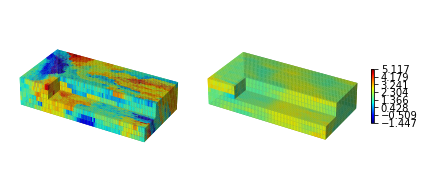

In [ ]:
i_start = 0

while 'xaya_{}.pkl'.format(i_start) in os.listdir('/content/drive/MyDrive/react_inverse/ILUES/kd_only/'):
  i_start += 1
with open('/content/drive/MyDrive/react_inverse/ILUES/kd_only/xaya_{}.pkl'.format(i_start-1), 'rb') as file:  
  [xf,yf] = pkl.load(file)
print(i_start)

with open('/content/drive/MyDrive/react_inverse/ILUES/3dkd.pkl', 'rb') as file:  
  real_hk = pkl.load(file)  

latent_z = np.mean(xf, axis = 1)
assert len(latent_z == 924), 'latent z dimension not correct.'
latent_z = torch.reshape(
          Tensor(latent_z), (-1, nf, d, h, w)
          )
# print(batch_z.shape)
with torch.no_grad():
    log_K = decoder(latent_z).cpu().numpy().reshape(-1, 6, 41, 81)
    del latent_z
    torch.cuda.empty_cache()
# fig = plot_3d(real_hk,title='real_kd', cut=[3, 12+1, 20-1])
fig = plot_3d_2(real_hk, log_K[0],title='kd_ilues', cut=[3, 12+1, 20-1])

In [ ]:


# vis_sensors_2(meas_data, np.reshape(np.mean(ya,axis=1), meas_data.shape), np.where(sensor), '')


In [ ]:
# with open('obs_sd.pkl', 'rb') as file:
#     meas = pkl.load(file)
Par=AttrDict()
Par.obs = meas[:,0] # observations
Par.sd  = meas[:,1] # standard deviations of the observation error
Par.Nobs = meas.shape[0]
Par.sensor = sensor
Par.Nlat = nf*d*h*w
Par.Nt = 10
Par.Nt_re = 5
Par.Npar = Par.Nlat

Par.N_iter = 20
Par.alpha = 0.1  # a scalar within [0 1]
Par.Ne = 1
Par.beta = np.sqrt(Par.N_iter)
Par.para_range = np.asarray(
    [
        [-5 for i in range(Par.Nlat)], #latent
        [5 for i in range(Par.Nlat)]
    ]
)
X = gen_init(Par) ##X: (N_para, Ne)
print('X shape: ', X.shape)

X shape:  (924, 1)


In [ ]:
real_latent_z = to_numpy(encoder(Tensor(real_hk.reshape(-1,1,6,41,81))))
X[:] = np.reshape(real_latent_z, (-1,1))

In [ ]:
xf = X
yf = run_surrogate(xf, Par, model, batch_size=1) ##Nobs, Ne

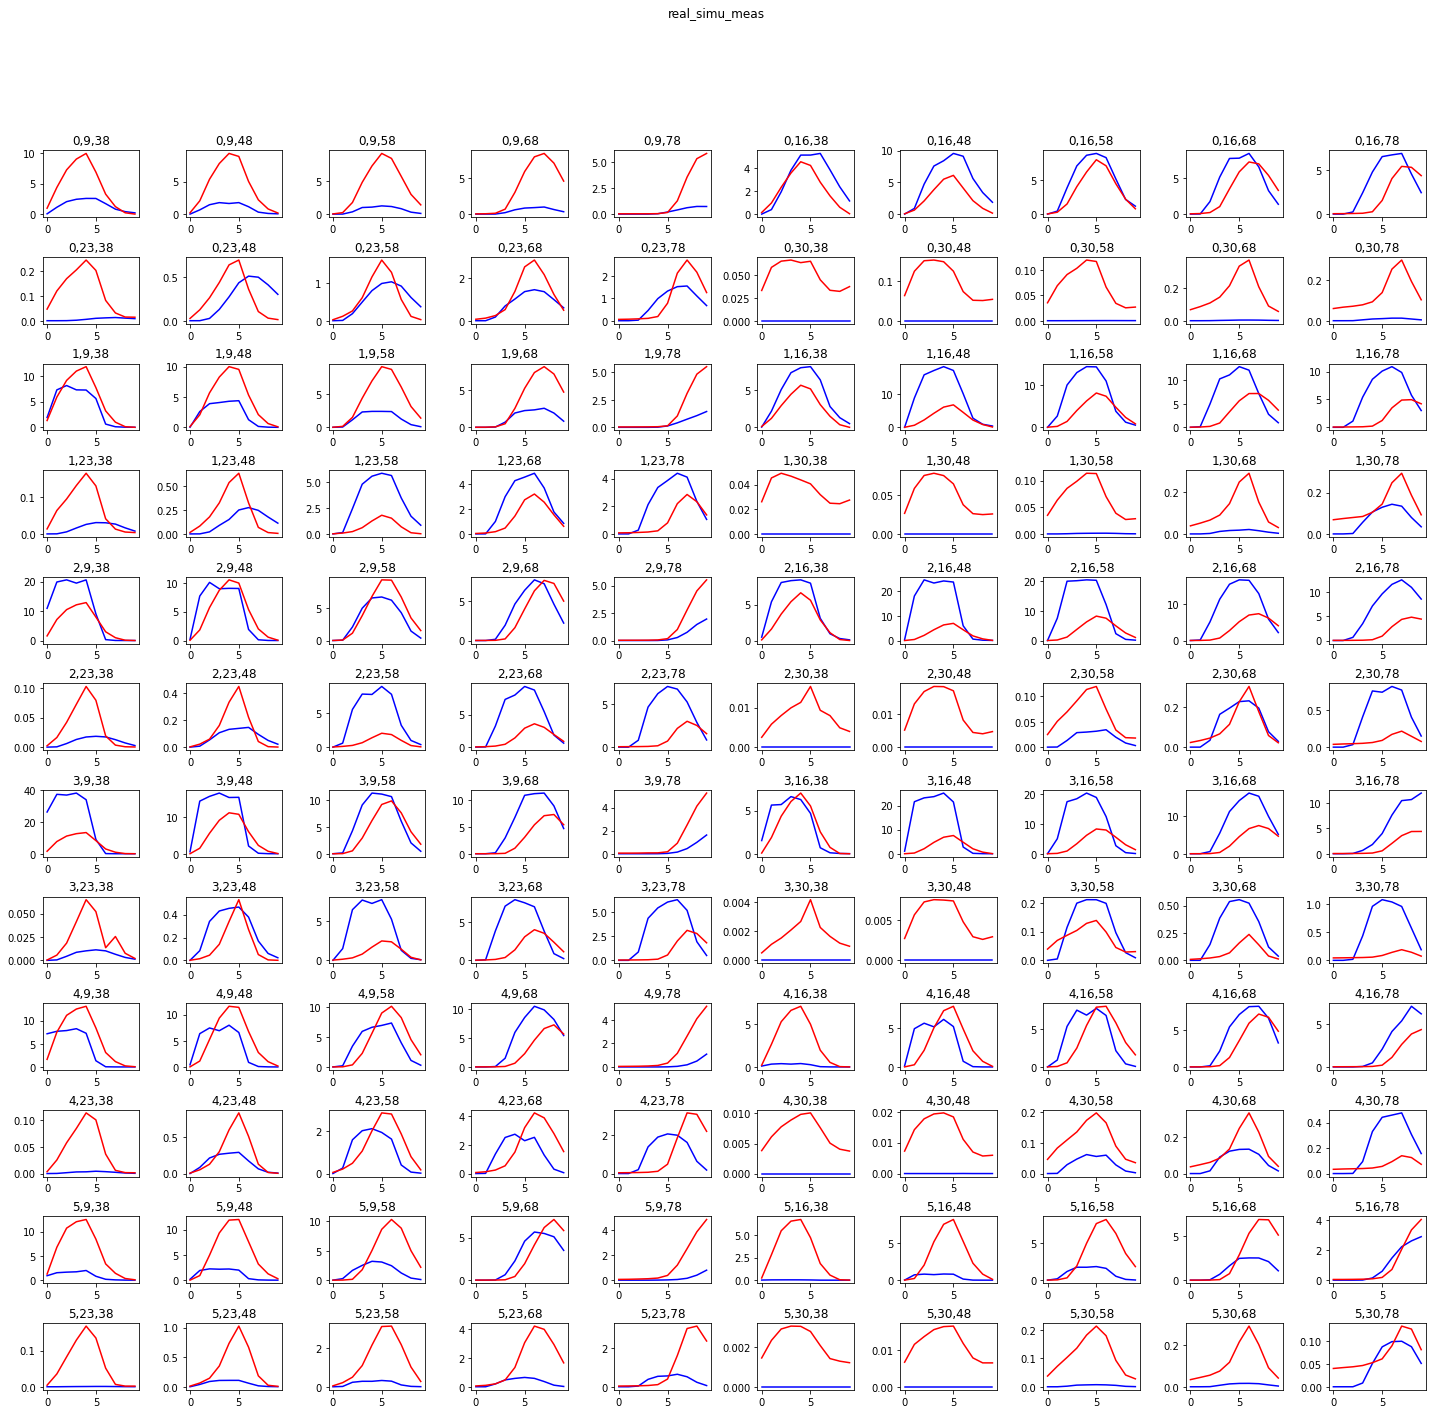

In [ ]:
vis_sensors_2(meas_data, np.reshape(np.mean(ya,axis=1), meas_data.shape), np.where(sensor), '')

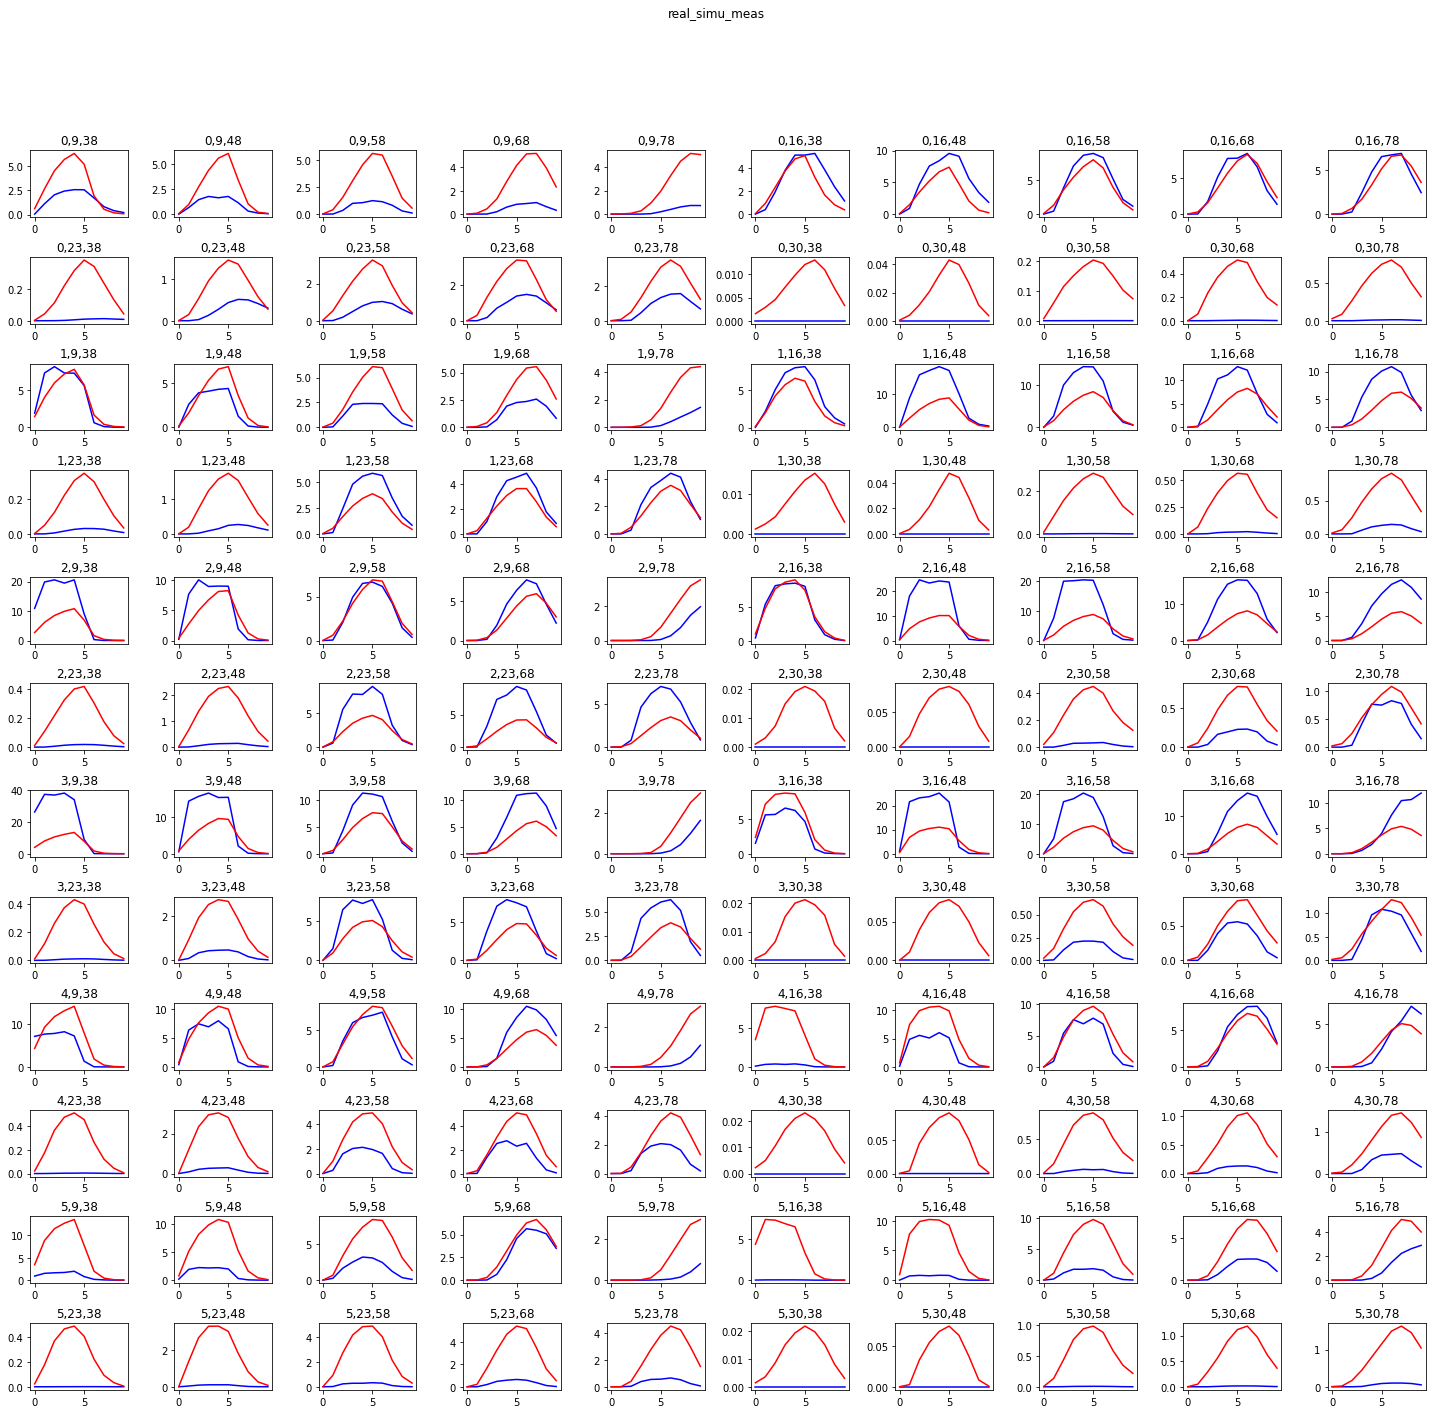

In [ ]:
vis_sensors_2(meas_data, np.reshape(yf, meas_data.shape), np.where(sensor), 'real_simu_meas')